# <font color="#30143">Preparación de los Datos </font>
<br><br>

---

Importación de Librerías

In [1]:
# Load libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

A continuación usamos la función `read_cvs()` de la libreria `pandas`para cargar los datos a nuestro entorno de trabajo. 

In [2]:
df = pd.read_csv("data_2017_2022.csv", sep=";")
df_1 = df.copy()
df_1["medicion"]=df_1["medicion"].str.replace(",", ".").astype("float") # convertir variable medición a númerica
df_1['fecha'] = pd.to_datetime(df_1['fecha']) # convertir variable fecha a datatime
df_1 = df_1.pivot(index=["fecha", "estacion"],columns= "variable", values="medicion").reset_index()
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473256 entries, 0 to 473255
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype              
---  ------            --------------   -----              
 0   fecha             473256 non-null  datetime64[ns, UTC]
 1   estacion          473256 non-null  object             
 2   black_carbon      8620 non-null    float64            
 3   direccion_viento  204419 non-null  float64            
 4   h2s               15353 non-null   float64            
 5   humedad           230887 non-null  float64            
 6   lluvia            260671 non-null  float64            
 7   no2               1 non-null       float64            
 8   o3                201936 non-null  float64            
 9   pm10              234568 non-null  float64            
 10  pm25              174546 non-null  float64            
 11  presion           209181 non-null  float64            
 12  radiacion_solar   221284 non-null  float64  

Para más practicidad se renombran las variables de nuestro conjunto de datos. 

In [3]:
df_1 = df_1.rename(columns={    
    'variable': 'var',
    'black_carbon': 'BC',
    'direccion_viento': 'WD',
    'humedad': 'HR',
    'lluvia': 'RF',
    'presion': 'P',
    'radiacion_solar': 'RS',
    'temperatura': 'AT',
    'temperatura_10_m': 'AT_10_m',
    'uv-pm': 'UV',
    'velocidad_viento': 'WS',
    'h2s': 'H2S',
    'no2': 'NO2',
    'o3': 'O3',
    'so2': 'SO2',
    'pm10': 'PM10',
    'pm25': 'PM2.5'  
})

Dado que la variable la variable $\text{NO}_2$ tiene solo $1$ medición entre $473.256$ registros durante el periodo analizado, lo que representa casi un $100\%$ de datos faltantes, hemos optado por excluirla del análisis.

In [4]:
df_t = df_1.copy()
df_t = df_t.drop(columns=["NO2"])

## <font color="#30143">  Detección y manejo de valores atípicos (outliers)</font>

### <font color="#30143">  Detección valores atípicos (outliers)</font>

A continuación, se realiza un análisis para identificar la presencia de `outliers` en nuestro conjunto de datos. Para esto usamos el método de detección de valores atípicos mediante las puntuaciones $ Z $, el cual establece el siguiente criterio: `Cualquier` dato cuya `puntuación esté fuera de la tercera desviación estándar es un valor atípico`. 

In [5]:
import numpy as np
import pandas as pd

def outliers_zscore(df, column_name, threshold=3):
    outliers = []
    mean = np.mean(df[column_name])
    std = np.std(df[column_name])
    
    for value in df[column_name]:
        z_score = (value - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(value)
    
    # Filtrar el DataFrame para incluir solo las filas con outliers
    outlier_df = df[df[column_name].isin(outliers)]
    
    # Devolver un DataFrame con la fecha y el valor del outlier
    return outlier_df[['fecha', column_name]]

In [6]:
from IPython.display import display, Markdown

display(Markdown('<center><img src="img/outlierszscores.png" alt="figure"></center>'))

<center><img src="img/outlierszscores.png" alt="figure"></center>

La función `outliers_zscore` recorrer todos los datos y calcular la puntuación $ Z $ para cada punto de datos utilizando la fórmula  $  \frac{(x_i - \mu)}{\sigma} $, donde $ x_i $ es cada valor de los datos, $ \mu $ es la media de los datos y $ \sigma $ es la desviación estándar de los datos. Luego, establece un umbral en la tercera desviación estandar e identifica como valores atípicos aquellos datos cuya puntuación $ Z $ (en valor absoluto) excede este umbral.  

Dada la naturaleza de las variables, se analizarán aquellas que muestran un patrón poco usal. 

A continuación, se observan los datos atípicos obtenidos luego de aplicar el método descrito anteriormente. 

In [7]:
df_out = df_t.copy()

P_outliers= outliers_zscore(df_out, 'P')
HR_outliers = outliers_zscore(df_out, 'HR')

print("Outliers a través Método Z-scores para la variable P: ", P_outliers)
print("Outliers a través Método Z-scores para la variable HR: ", HR_outliers)

Outliers a través Método Z-scores para la variable P:  variable                     fecha      P
377835   2021-10-16 05:59:59+00:00  613.5
390640   2021-12-14 12:59:59+00:00  573.1
447032   2022-09-01 14:59:59+00:00   27.7
Outliers a través Método Z-scores para la variable HR:  variable                     fecha    HR
53048    2017-09-03 14:59:59+00:00  20.7
121286   2018-07-16 12:59:59+00:00  22.3
121295   2018-07-16 13:59:59+00:00  21.4
126281   2018-08-08 15:59:59+00:00  21.1
126290   2018-08-08 16:59:59+00:00  22.0
...                            ...   ...
282872   2020-08-02 14:59:59+00:00  16.8
282881   2020-08-02 15:59:59+00:00  17.3
283106   2020-08-03 16:59:59+00:00  22.1
371649   2021-09-17 14:59:59+00:00  21.6
371650   2021-09-17 14:59:59+00:00  21.0

[72 rows x 2 columns]


### <font color="#30143"> Procesamiento de valores atípicos (outliers)</font>

A continuación se define función `data_by_date()`para extraer las mediciones y resumen estadístico de las características según la fecha y función `re_value_with_median()` para reemplazar los datos por la mediana de las mediciones de la característica registrada en la fecha correspondiente.

In [8]:
import pandas as pd

def data_by_date_with_outliers(outlier_df, original_df, column_name):
    # Ensure the 'fecha' column in both DataFrames is of datetime type
    outlier_df['fecha'] = pd.to_datetime(outlier_df['fecha'], errors='coerce')
    original_df['fecha'] = pd.to_datetime(original_df['fecha'], errors='coerce')
    
    # Get all unique dates in the outlier DataFrame
    fechas_unicas = outlier_df['fecha'].dt.date.unique()
    
    # Prepare list to store results
    results = []
    
    for date in fechas_unicas:
        # Filter the original DataFrame for the specific date
        filtered_data = original_df[original_df['fecha'].dt.date == date][['fecha', column_name]]
        
        # Filter the outlier DataFrame for the specific date
        outlier_data = outlier_df[outlier_df['fecha'].dt.date == date]
        
        # Prepare statistics
        stats = filtered_data[column_name].describe() if not filtered_data.empty else pd.Series({"count": 0})
        
        # Create result dictionary
        result = {
            'date': date,
            'count': stats['count'],
            'mean': stats['mean'] if 'mean' in stats else None,
            'std': stats['std'] if 'std' in stats else None,
            'min': stats['min'] if 'min' in stats else None,
            '25%': stats['25%'] if '25%' in stats else None,
            '50%': stats['50%'] if '50%' in stats else None,
            '75%': stats['75%'] if '75%' in stats else None,
            'max': stats['max'] if 'max' in stats else None,
            'outliers': outlier_data[column_name].tolist() if not outlier_data.empty else []
        }
        results.append(result)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [9]:
import pandas as pd
import numpy as np

def re_value_with_median(df, column, df_Outlier):
    df['fecha'] = pd.to_datetime(df['fecha'])
    df_Outlier['date'] = pd.to_datetime(df_Outlier['date'])

    # Inicializar un log para rastrear los reemplazos
    log = []

    # Iterar sobre cada fila en df_Outlier
    for _, row in df_Outlier.iterrows():
        date = row['date'].date()
        outlier_values = row['outliers']

        # Asegurarse de que outlier_values sea una lista
        if not isinstance(outlier_values, list):
            outlier_values = [outlier_values]

        # Filtrar df para la fecha específica
        df_date = df[df['fecha'].dt.date == date]

        # Calcular la mediana de la columna para esa fecha específica
        median_value = df_date[column].median()

        # Reemplazar los valores outlier con la mediana calculada
        for value in outlier_values:
            df.loc[(df['fecha'].dt.date == date) & (df[column] == value), column] = median_value
            log.append((date, value, median_value))

    return df, log

#### <font color="#30143"> Valores atípicos (outliers) para Presión Atmosférica (P) </font>

A continuación se visualizan los datos atipicos para la variable `presión atmosférica` y un análisis descriptivo por fecha en la cual se detectaron estas mediciones dudosas. 

In [10]:
df_Out_P = data_by_date_with_outliers(P_outliers, df_t, 'P')
print(df_Out_P)

         date  count        mean        std    min      25%    50%    75%  \
0  2021-10-16  148.0  903.601351  24.186574  613.5  903.275  905.5  907.9   
1  2021-12-14  141.0  901.201418  27.965262  573.1  901.400  903.9  905.3   
2  2022-09-01  168.0  899.004167  67.694357   27.7  902.000  904.2  906.4   

     max outliers  
0  912.0  [613.5]  
1  909.5  [573.1]  
2  910.7   [27.7]  


In [11]:
df_t2, log = re_value_with_median(df_t, 'P', df_Out_P)

# Mostrar los primeros registros del log
print("Primeros 5 reemplazos:")
for entry in log[:5]:
    print(f"Fecha: {entry[0]}, Valor reemplazado: {entry[1]}, Nuevo valor: {entry[2]}")

Primeros 5 reemplazos:
Fecha: 2021-10-16, Valor reemplazado: 613.5, Nuevo valor: 905.5
Fecha: 2021-12-14, Valor reemplazado: 573.1, Nuevo valor: 903.9
Fecha: 2022-09-01, Valor reemplazado: 27.7, Nuevo valor: 904.2


Verificamos que efectivamente los valores hayan sido reemplazados, para lo anterior ejecutamos nuevamente la función `outliers_zscore()`.

In [12]:
P_outliers2= outliers_zscore(df_t2, 'P')
print("Outliers a través Método Z-scores para la variable P: ", P_outliers2)

Outliers a través Método Z-scores para la variable P:  Empty DataFrame
Columns: [fecha, P]
Index: []


#### <font color="#30143"> Valores atípicos (outliers) para Humedad Relativa (HR) </font>

A continuación se visualizan los datos atipicos para la variable Humedad Relativa y un análisis descriptivo por fecha en la cual se detectaron estas mediciones dudosas. 

In [13]:
df_Out_HR = data_by_date_with_outliers(HR_outliers, df_t, 'HR')
print(df_Out_HR)

          date  count       mean        std   min     25%    50%     75%  \
0   2017-09-03   24.0  50.283333  16.951918  20.7  35.375  54.40  64.150   
1   2018-07-16   48.0  51.239583  15.232534  21.4  40.775  52.65  62.525   
2   2018-08-08   48.0  59.979167  19.691860  21.1  43.775  63.40  71.150   
3   2018-08-11   48.0  55.291667  18.714414  20.2  41.075  55.20  69.450   
4   2019-01-01   72.0  58.412500  20.121371  21.1  43.225  57.30  72.925   
5   2019-08-05   96.0  54.932292  18.548034  20.1  39.225  56.65  70.625   
6   2019-08-12   96.0  56.098958  17.518571  19.5  42.825  56.45  70.400   
7   2019-08-14   89.0  48.724719  19.769497  18.7  30.600  52.00  66.200   
8   2019-08-15   77.0  42.412987  14.326534  12.8  34.200  44.20  51.700   
9   2019-08-21   96.0  51.540625  19.239726  15.2  38.600  54.05  65.275   
10  2019-08-22   96.0  54.729167  16.393265  20.0  43.875  57.15  64.200   
11  2019-08-23   96.0  53.192708  17.258171  18.9  40.500  54.10  66.875   
12  2019-08-

In [14]:
df_t2, log = re_value_with_median(df_t, 'HR', df_Out_HR)

# Mostrar los primeros registros del log
print("Primeros 5 reemplazos:")
for entry in log[:5]:
    print(f"Fecha: {entry[0]}, Valor reemplazado: {entry[1]}, Nuevo valor: {entry[2]}")

Primeros 5 reemplazos:
Fecha: 2017-09-03, Valor reemplazado: 20.7, Nuevo valor: 54.400000000000006
Fecha: 2018-07-16, Valor reemplazado: 22.3, Nuevo valor: 52.65
Fecha: 2018-07-16, Valor reemplazado: 21.4, Nuevo valor: 52.65
Fecha: 2018-08-08, Valor reemplazado: 21.1, Nuevo valor: 63.4
Fecha: 2018-08-08, Valor reemplazado: 22.0, Nuevo valor: 63.4


In [15]:
HR_outliers2= outliers_zscore(df_t2, 'HR')
print("Outliers a través Método Z-scores para la variable HR: ", HR_outliers2)

Outliers a través Método Z-scores para la variable HR:  variable                     fecha    HR
157808   2019-01-01 14:59:59+00:00  22.4
208140   2019-08-22 14:59:59+00:00  22.4


## <font color="#30143"> Datos faltantes Estación Compartir </font>

A continuación observamos el resumen de datos faltantes para cada característica del conjunto de datos de la `Estación Compartir`. 

In [16]:
df_compartir_2  = df_t2[df_t2['estacion'] == 'compartir']
df_compartir_drop = df_compartir_2.drop(columns=['BC', 'SO2', 'UV', 'H2S', 'AT_10_m'])

# Iterar a través de las columnas usando nombres de columnas en lugar de índices
for column in df_compartir_drop.columns:
    n_miss = df_compartir_drop[[column]].isnull().sum()  # Usar el nombre de la columna
    perc = n_miss / df_compartir_drop.shape[0] * 100
    print('> %s, Missing: %d (%.1f%%)' % (column, n_miss, perc))

> fecha, Missing: 0 (0.0%)
> estacion, Missing: 0 (0.0%)
> WD, Missing: 3033 (5.8%)
> HR, Missing: 7051 (13.4%)
> RF, Missing: 3034 (5.8%)
> O3, Missing: 17442 (33.2%)
> PM10, Missing: 14301 (27.2%)
> PM2.5, Missing: 19804 (37.7%)
> P, Missing: 3034 (5.8%)
> RS, Missing: 3189 (6.1%)
> AT, Missing: 3042 (5.8%)
> WS, Missing: 3033 (5.8%)


## <font color="#30143"> Técnicas de Imputación de datos faltantes</font>

Procedemos a depurar el conjunto de datos, excluyendo aquellas columnas que carecen de información. Posteriormente, nos enfocamos en examinar detalladamente la presencia de valores faltantes  en cada variable de manera independiente. Este enfoque meticuloso nos permitirá determinar e implementar la estrategia de imputación más apropiada para cada caso, asegurando así la integridad y calidad de nuestros datos para los análisis subsiguientes.

In [17]:
df_compartir_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52584 entries, 2 to 473249
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   fecha     52584 non-null  datetime64[ns, UTC]
 1   estacion  52584 non-null  object             
 2   WD        49551 non-null  float64            
 3   HR        45533 non-null  float64            
 4   RF        49550 non-null  float64            
 5   O3        35142 non-null  float64            
 6   PM10      38283 non-null  float64            
 7   PM2.5     32780 non-null  float64            
 8   P         49550 non-null  float64            
 9   RS        49395 non-null  float64            
 10  AT        49542 non-null  float64            
 11  WS        49551 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(10), object(1)
memory usage: 5.2+ MB


In [18]:
# Encuentra valores que no se pueden convertir a datetime
invalid_dates_drop = df_compartir_drop[pd.to_datetime(df_compartir_drop['fecha'], errors='coerce').isna()]
print(invalid_dates_drop)

Empty DataFrame
Columns: [fecha, estacion, WD, HR, RF, O3, PM10, PM2.5, P, RS, AT, WS]
Index: []


La función `plot_impute()` genera el gráfico de comparación de los datos originales e imputados. 

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_impute(df, original_col, imputed_col, title):
   
    # Configurar el estilo de seaborn
    sns.set_style("whitegrid")
    
    # Crear la figura y los ejes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Verificar si las columnas existen
    if original_col not in df.columns or imputed_col not in df.columns:
        raise KeyError(f"Una de las columnas requeridas no existe en el DataFrame: '{original_col}' o '{imputed_col}'")

    full_title = f"Serie de tiempo y datos imputados: {title}"

    # Gráfico de serie de tiempo
    ax1.plot(df['fecha'], df[original_col], color='blue', linestyle='-', linewidth=2, label=f'Original {original_col}')
    ax1.plot(df['fecha'], df[imputed_col], color='red', linestyle='--', linewidth=2, label=f'Imputado {imputed_col}', alpha=0.7)

    ax1.set_title(full_title, fontsize=16)
    ax1.set_xlabel('Tiempo', fontsize=12)
    ax1.set_ylabel('Valor', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.tick_params(axis='both', which='major', labelsize=10)

    # Gráfico de densidad
    sns.kdeplot(data=df[original_col].dropna(), shade=True, color="blue", ax=ax2, label=f'Original {original_col}')
    sns.kdeplot(data=df[imputed_col].dropna(), shade=True, color="red", ax=ax2, label=f'Imputado {imputed_col}')

    ax2.set_title('Gráfico de densidad', fontsize=16)
    ax2.set_xlabel('Valor', fontsize=12)
    ax2.set_ylabel('Densidad', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    plt.show()

### <font color="#30143">Imputación usando la última observación </font>

In [20]:
# Separar las columnas numéricas y no numéricas
df_non_numeric = df_compartir_drop[['fecha', 'estacion']]
df_numeric = df_compartir_drop.drop(columns=['fecha', 'estacion'])

# Aplicar LOCF a todas las columnas numéricas
df_imputed0 = df_numeric.fillna(method='ffill')

# Añadir sufijo a las columnas imputadas
df_imputed0.columns = [col + '_LOCF' for col in df_imputed0.columns]

# Concatenar el DataFrame original completo con el DataFrame imputado
df_combined0 = pd.concat([df_compartir_drop.reset_index(drop=True), df_imputed0.reset_index(drop=True)], axis=1)

A continuación se aplicará la prueba U de Mann-Whitney para comparar la distribución de los datos originales con valores faltantes y los datos imputados. La hipótesis nula de la prueba es que las dos muestras (datos originales y datos imputados) provienen de la misma distribución.  

Un resultado no significativo (p-valor alto) indicaría que no hay evidencia suficiente para rechazar la hipótesis nula, sugiriendo que la imputación no ha alterado significativamente la distribución de los datos originales.

* Si el p-valor es alto: Esto indicaría que las distribuciones de los datos originales y los datos imputados son similares, lo que sugiere que la imputación ha mantenido las características estadísticas de los datos originales, validando así la adecuación del proceso de imputación.
  
* Si el p-valor es bajo: Esto sugeriría que las distribuciones son diferentes, lo que podría indicar que la imputación ha introducido sesgos o alteraciones significativas en los datos.

In [21]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Excluir las columnas que no se deben incluir en la prueba
columns_to_exclude = ['fecha', 'estacion']

# Seleccionar solo las columnas numéricas originales y sus correspondientes imputadas
original_columns = [col for col in df_combined0.columns if col not in columns_to_exclude and not col.endswith('_LOCF')]
imputed_columns = [col for col in df_combined0.columns if col.endswith('_LOCF')]

# Iterar sobre las columnas originales e imputadas correspondientes
for original_col in original_columns:
    imputed_col = original_col + '_LOCF'
    
    if imputed_col in imputed_columns:
        # Asegurarse de que la columna existe en el DataFrame
        original_data = df_combined0[original_col].dropna()
        imputed_data = df_combined0[imputed_col].dropna()
        
        # Realizar la prueba de Mann-Whitney U
        stat, p_value = mannwhitneyu(original_data, imputed_data, alternative='two-sided')
        
        print(f"Atributo '{original_col}':")
        print(f"Mann-Whitney U Test: statistic={stat:.2f}, p-value={p_value:.4f}")
        print()  # Línea en blanco para separar los resultados de cada columna
        
        # Interpretar el resultado
        alpha = 0.05  # Nivel de significancia
        if p_value < alpha:
            print(f"Diferencia significativa detectada (p-valor < {alpha})")
        else:
            print(f"No se detectó diferencia significativa (p-valor ≥ {alpha})")
        
        print()  # Línea en blanco para separar los resultados de cada columna

Atributo 'WD':
Mann-Whitney U Test: statistic=1282124180.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'HR':
Mann-Whitney U Test: statistic=1089059912.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'RF':
Mann-Whitney U Test: statistic=1301954392.00, p-value=0.7023

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'O3':
Mann-Whitney U Test: statistic=1052264522.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'PM10':
Mann-Whitney U Test: statistic=954672847.50, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'PM2.5':
Mann-Whitney U Test: statistic=827354546.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'P':
Mann-Whitney U Test: statistic=1304957641.50, p-value=0.6420

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'RS':
Mann-Whitney U Test: statistic=1311586060.00, p-value=0.0057

Dif

Dados los resultados obtenidos de la prueba `U de Mann-Whitney`, se observa que, con la excepción del atributo `RF` y `P`, todos los demás atributos presentan un `p-valor` inferior a $0.05$. Lo que sugiere que existen diferencias significativas entre las distribuciones de los datos originales y los datos imputados. Lo que indica que el proceso de imputación ha alterado significativamente las características estadísticas de la mayoría de los atributos. 

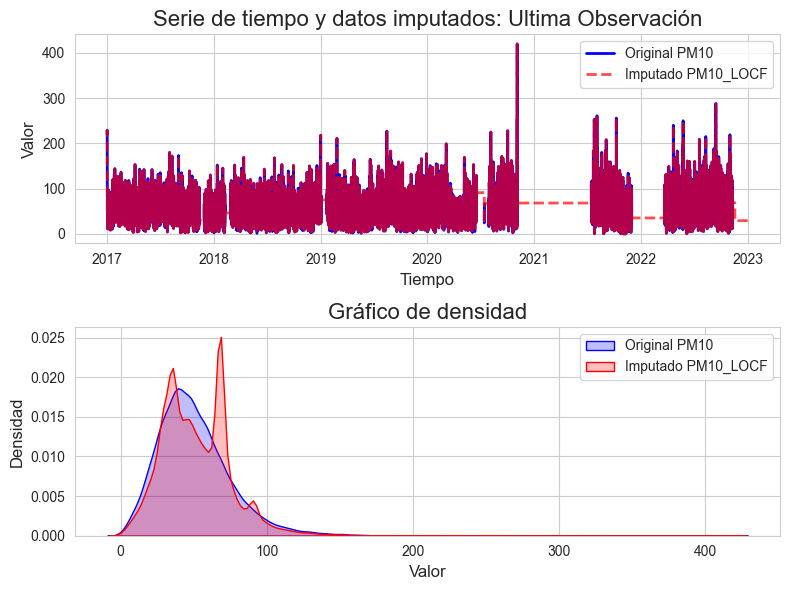

In [22]:
plot_impute(df_combined0, 'PM10', 'PM10_LOCF',  'Ultima Observación')

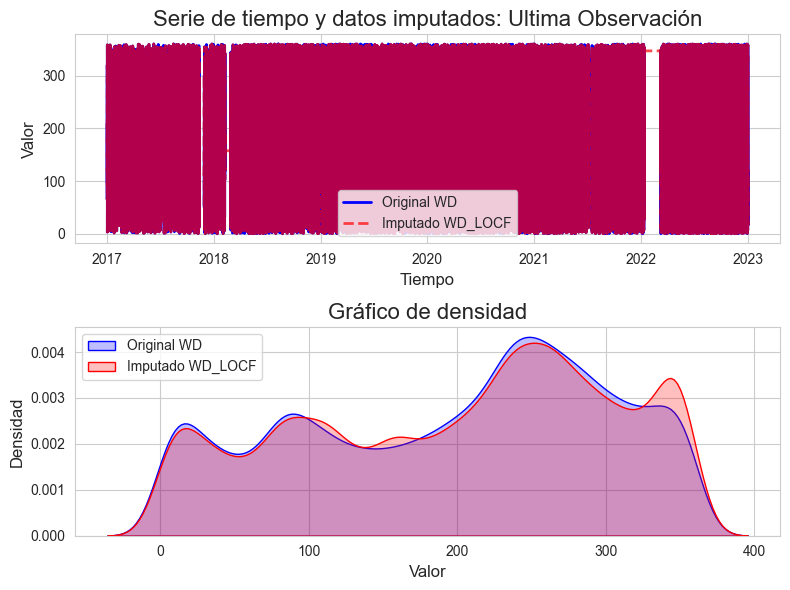

In [23]:
plot_impute(df_combined0, 'WD', 'WD_LOCF',  'Ultima Observación')

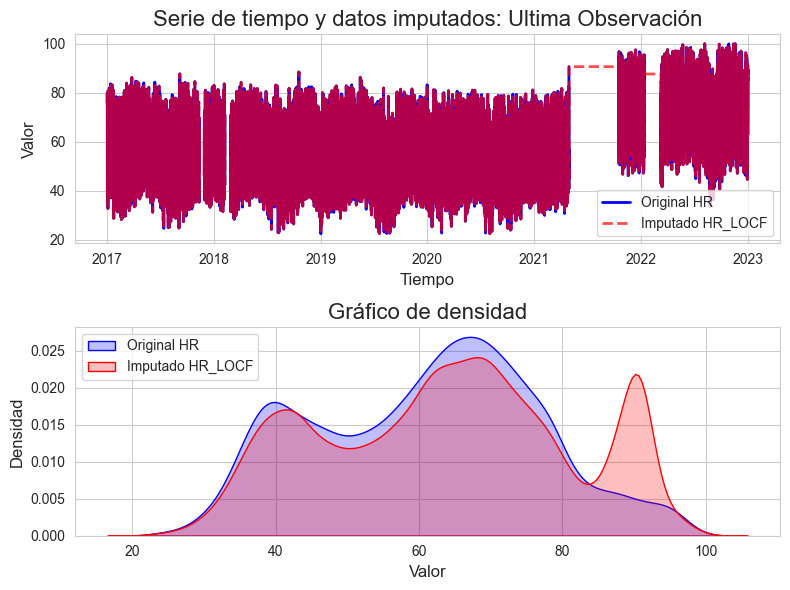

In [24]:
plot_impute(df_combined0, 'HR', 'HR_LOCF',  'Ultima Observación')

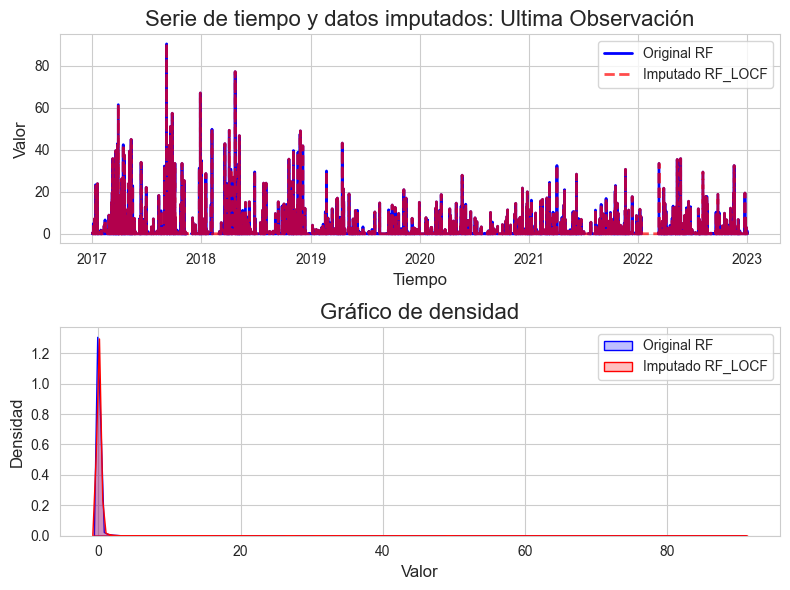

In [25]:
plot_impute(df_combined0, 'RF', 'RF_LOCF',  'Ultima Observación')

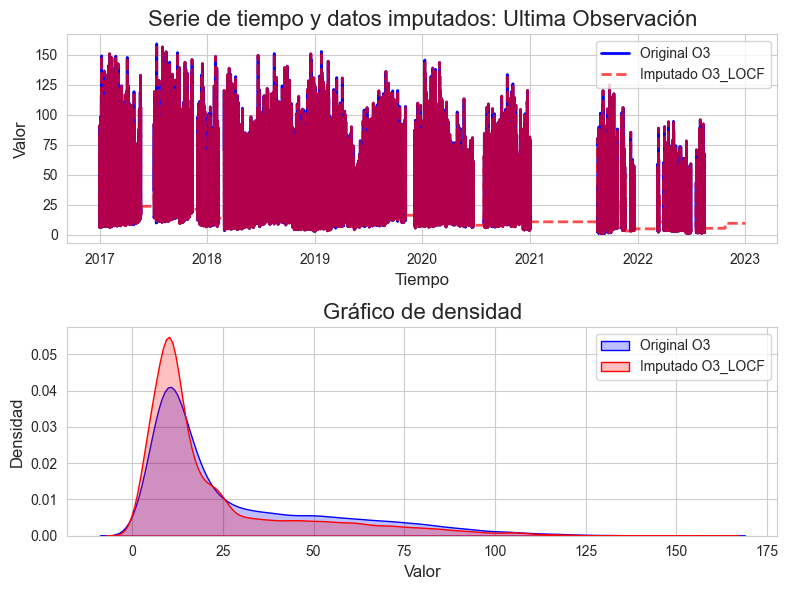

In [26]:
plot_impute(df_combined0, 'O3', 'O3_LOCF',  'Ultima Observación')

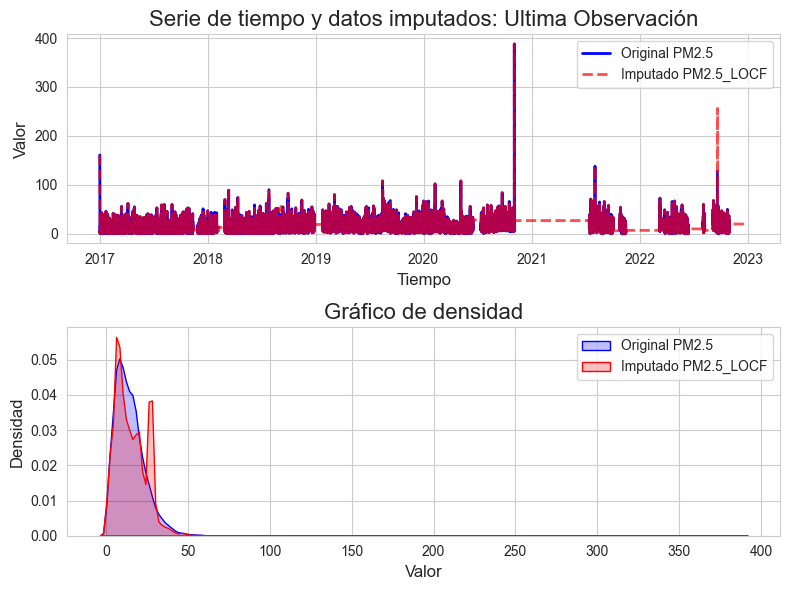

In [27]:
plot_impute(df_combined0, 'PM2.5', 'PM2.5_LOCF',  'Ultima Observación')

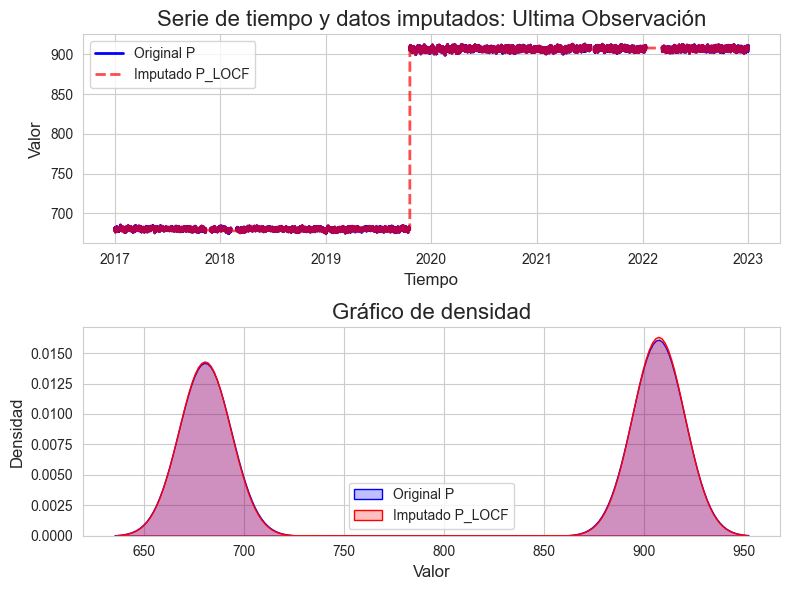

In [28]:
plot_impute(df_combined0, 'P', 'P_LOCF',  'Ultima Observación')

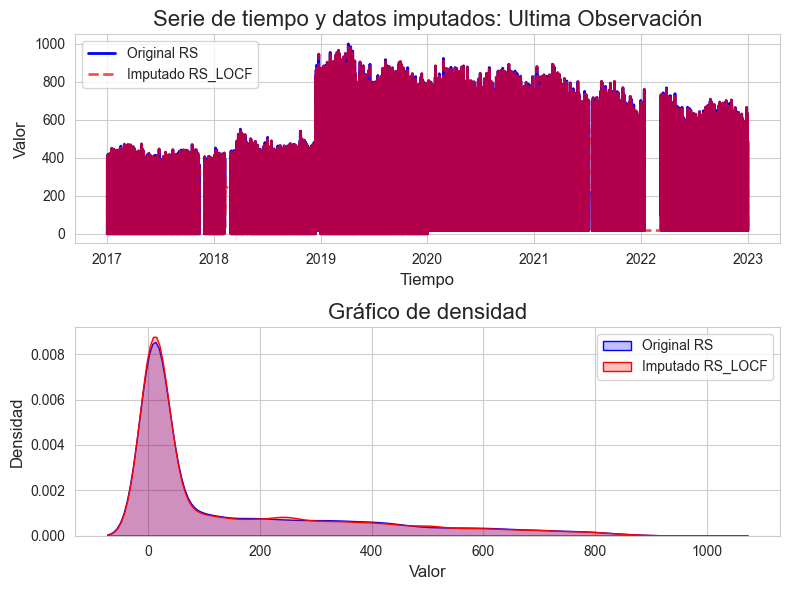

In [29]:
plot_impute(df_combined0, 'RS', 'RS_LOCF',  'Ultima Observación')

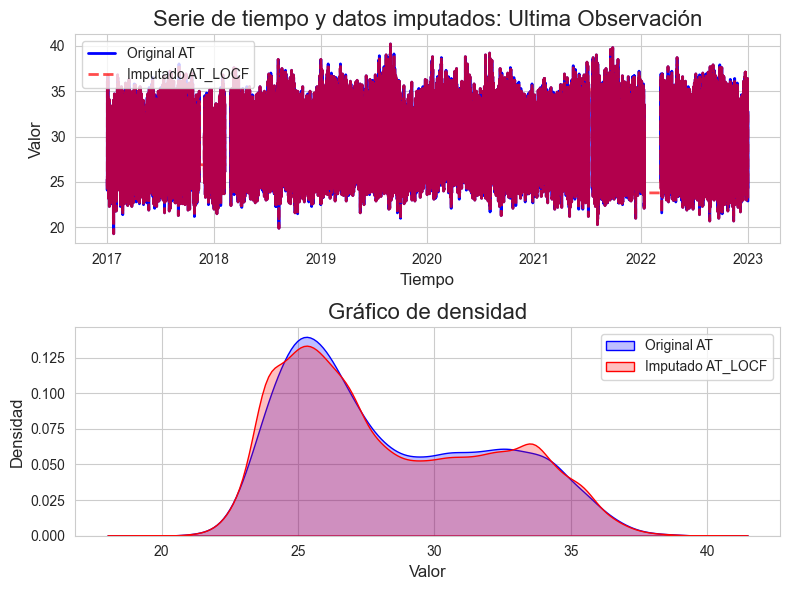

In [30]:
plot_impute(df_combined0, 'AT', 'AT_LOCF',  'Ultima Observación')

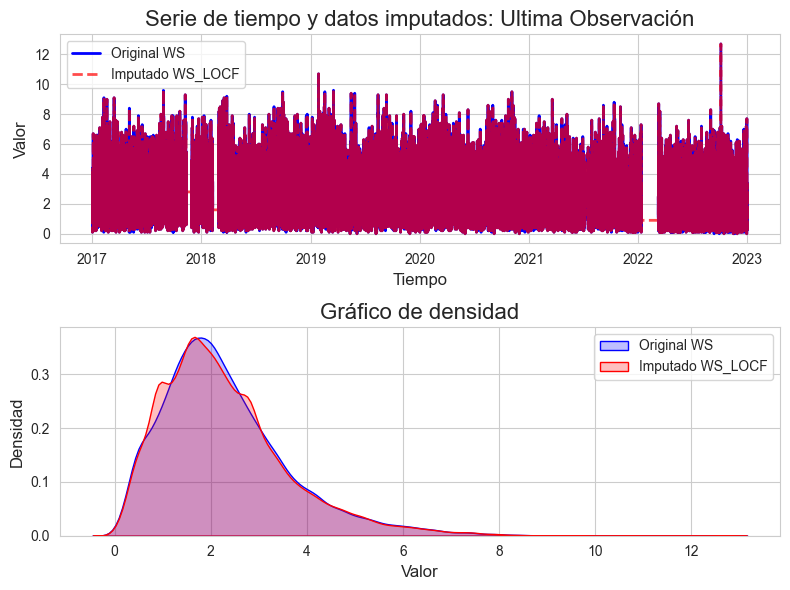

In [31]:
plot_impute(df_combined0, 'WS', 'WS_LOCF',  'Ultima Observación')

### <font color="#30143">Imputación usando KNNImputer() </font>

In [32]:
import pandas as pd
from sklearn.impute import KNNImputer

# Separar las columnas numéricas y no numéricas
df_non_numeric = df_compartir_drop[['fecha', 'estacion']]
df_numeric = df_compartir_drop.drop(columns=['fecha', 'estacion'])

# Inicializa el KNNImputer
imputer1 = KNNImputer()

# Imputa solo las columnas numéricas
df_imputed_array1 = imputer1.fit_transform(df_numeric)

# Crear un DataFrame a partir del array de NumPy, especificando las columnas
df_imputed1 = pd.DataFrame(df_imputed_array1, columns=df_numeric.columns)

# Añadir sufijo a las columnas imputadas
df_imputed1.columns = [col + '_imputedKnnImput' for col in df_imputed1.columns]

# Concatenar el DataFrame original completo con el DataFrame imputado
df_combined1 = pd.concat([df_compartir_drop.reset_index(drop=True), df_imputed1.reset_index(drop=True)], axis=1)

In [33]:
df_combined1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   fecha                  52584 non-null  datetime64[ns, UTC]
 1   estacion               52584 non-null  object             
 2   WD                     49551 non-null  float64            
 3   HR                     45533 non-null  float64            
 4   RF                     49550 non-null  float64            
 5   O3                     35142 non-null  float64            
 6   PM10                   38283 non-null  float64            
 7   PM2.5                  32780 non-null  float64            
 8   P                      49550 non-null  float64            
 9   RS                     49395 non-null  float64            
 10  AT                     49542 non-null  float64            
 11  WS                     49551 non-null  float64        

A continuación se aplicará la prueba U de Mann-Whitney para comparar la distribución de los datos originales con valores faltantes y los datos imputados. La hipótesis nula de la prueba es que las dos muestras (datos originales y datos imputados) provienen de la misma distribución.  

Un resultado no significativo (p-valor alto) indicaría que no hay evidencia suficiente para rechazar la hipótesis nula, sugiriendo que la imputación no ha alterado significativamente la distribución de los datos originales.

* Si el p-valor es alto: Esto indicaría que las distribuciones de los datos originales y los datos imputados son similares, lo que sugiere que la imputación ha mantenido las características estadísticas de los datos originales, validando así la adecuación del proceso de imputación.
  
* Si el p-valor es bajo: Esto sugeriría que las distribuciones son diferentes, lo que podría indicar que la imputación ha introducido sesgos o alteraciones significativas en los datos.

In [34]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Excluir las columnas que no se deben incluir en la prueba
columns_to_exclude = ['fecha', 'estacion']

# Seleccionar solo las columnas numéricas originales y sus correspondientes imputadas
original_columns = [col for col in df_combined1.columns if col not in columns_to_exclude and not col.endswith('_imputedKnnImput')]
imputed_columns = [col for col in df_combined1.columns if col.endswith('_imputedKnnImput')]

# Iterar sobre las columnas originales e imputadas correspondientes
for original_col in original_columns:
    imputed_col = original_col + '_imputedKnnImput'
    
    if imputed_col in imputed_columns:
        # Asegurarse de que la columna existe en el DataFrame
        original_data = df_combined1[original_col].dropna()
        imputed_data = df_combined1[imputed_col].dropna()
        
        # Realizar la prueba de Mann-Whitney U
        stat, p_value = mannwhitneyu(original_data, imputed_data, alternative='two-sided')
        
        print(f"Atributo '{original_col}':")
        print(f"Mann-Whitney U Test: statistic={stat:.2f}, p-value={p_value:.4f}")
        print()  # Línea en blanco para separar los resultados de cada columna
        
        # Interpretar el resultado
        alpha = 0.05  # Nivel de significancia
        if p_value < alpha:
            print(f"Diferencia significativa detectada (p-valor < {alpha})")
        else:
            print(f"No se detectó diferencia significativa (p-valor ≥ {alpha})")
        
        print()  # Línea en blanco para separar los resultados de cada columna

Atributo 'WD':
Mann-Whitney U Test: statistic=1312022179.50, p-value=0.0501

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'HR':
Mann-Whitney U Test: statistic=1193362865.00, p-value=0.3916

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'RF':
Mann-Whitney U Test: statistic=1238494138.50, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'O3':
Mann-Whitney U Test: statistic=933559022.00, p-value=0.0090

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'PM10':
Mann-Whitney U Test: statistic=980731635.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'PM2.5':
Mann-Whitney U Test: statistic=821134335.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'P':
Mann-Whitney U Test: statistic=1307284419.50, p-value=0.3376

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'RS':
Mann-Whitney U Test: statistic=1273810218.50, p-value=0.0000



Dados los resultados obtenidos de la prueba `U de Mann-Whitney`, se observa que, con la excepción del atributo `WD`, `HR` y `P`, todos los demás atributos presentan un `p-valor` inferior a $0.05$. Lo que sugiere que existen diferencias significativas entre las distribuciones de los datos originales y los datos imputados. Lo que indica que el proceso de imputación ha alterado significativamente las características estadísticas de la mayoría de los atributos. 

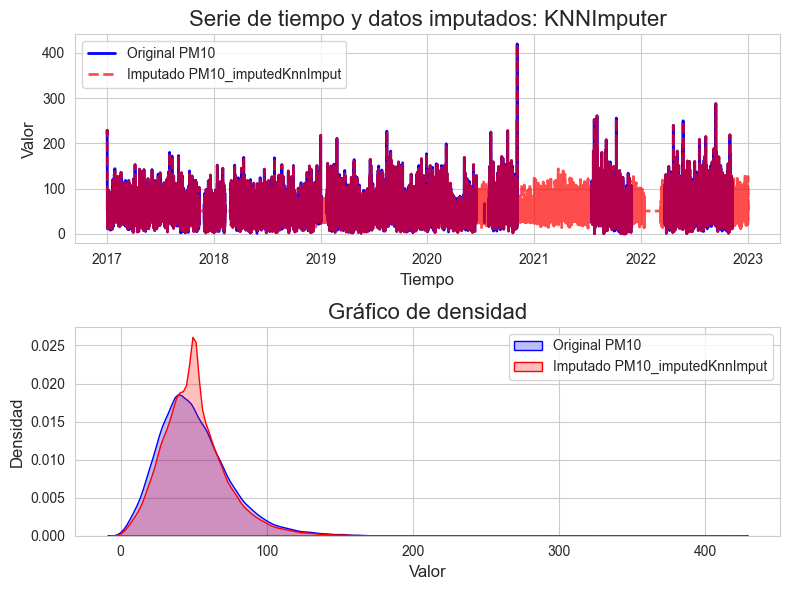

In [35]:
plot_impute(df_combined1, 'PM10', 'PM10_imputedKnnImput',  'KNNImputer')

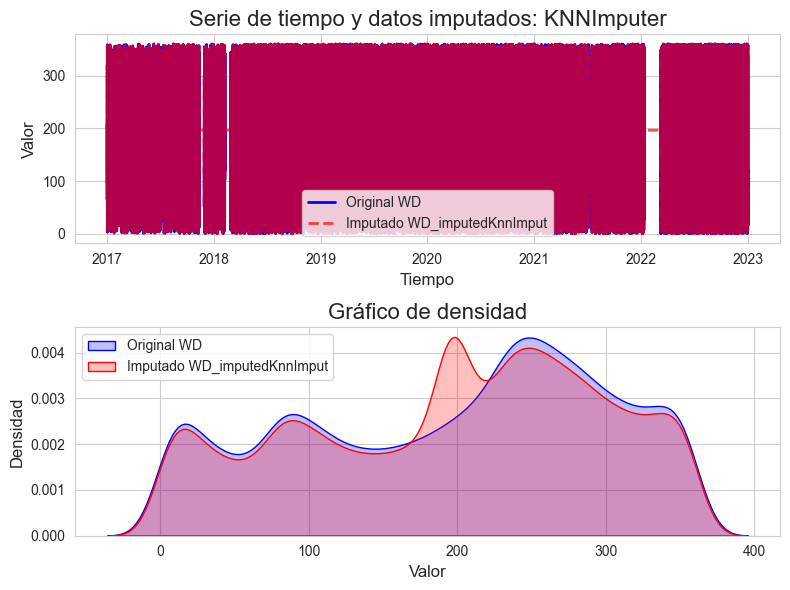

In [36]:
plot_impute(df_combined1, 'WD', 'WD_imputedKnnImput',  'KNNImputer')

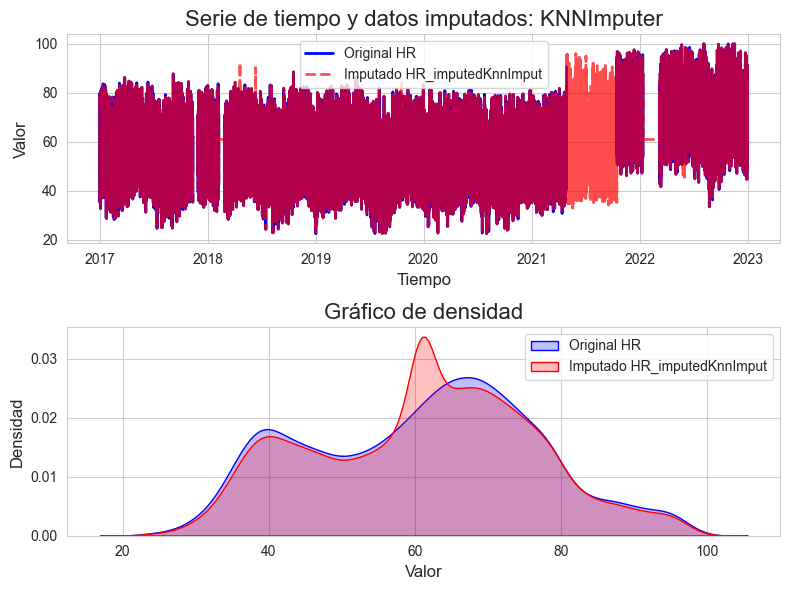

In [37]:
plot_impute(df_combined1, 'HR', 'HR_imputedKnnImput',  'KNNImputer')

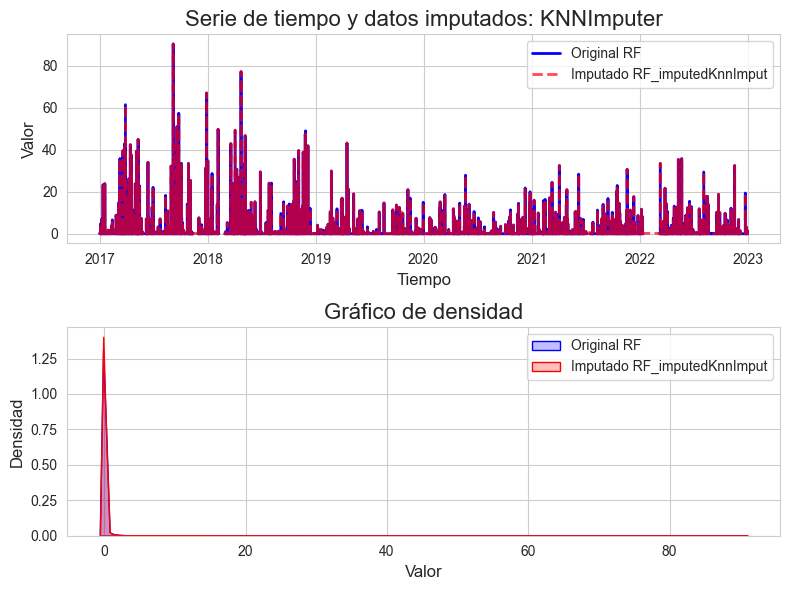

In [38]:
plot_impute(df_combined1, 'RF', 'RF_imputedKnnImput',  'KNNImputer')

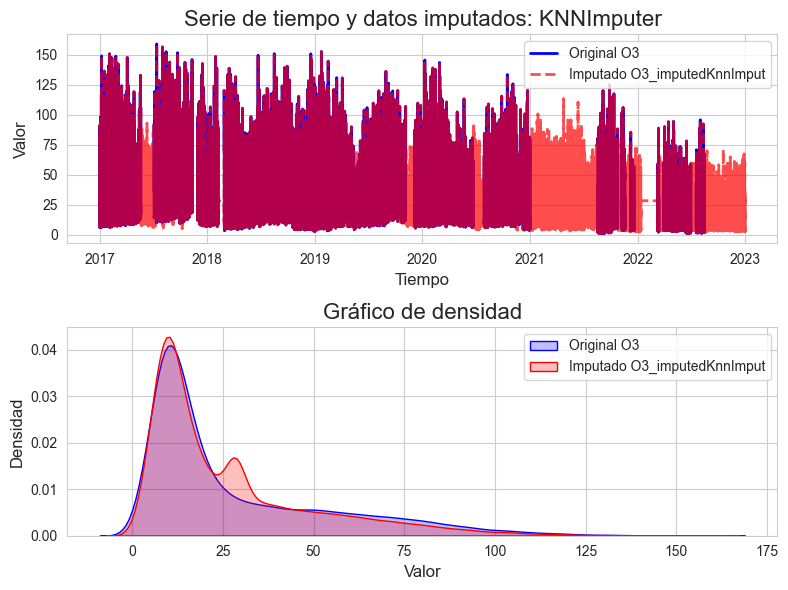

In [39]:
plot_impute(df_combined1, 'O3', 'O3_imputedKnnImput',  'KNNImputer')

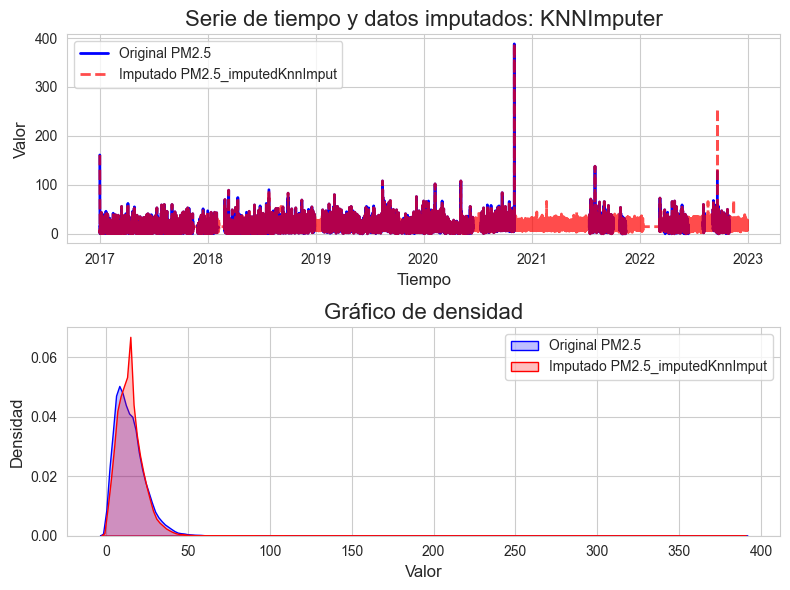

In [40]:
plot_impute(df_combined1, 'PM2.5', 'PM2.5_imputedKnnImput',  'KNNImputer')

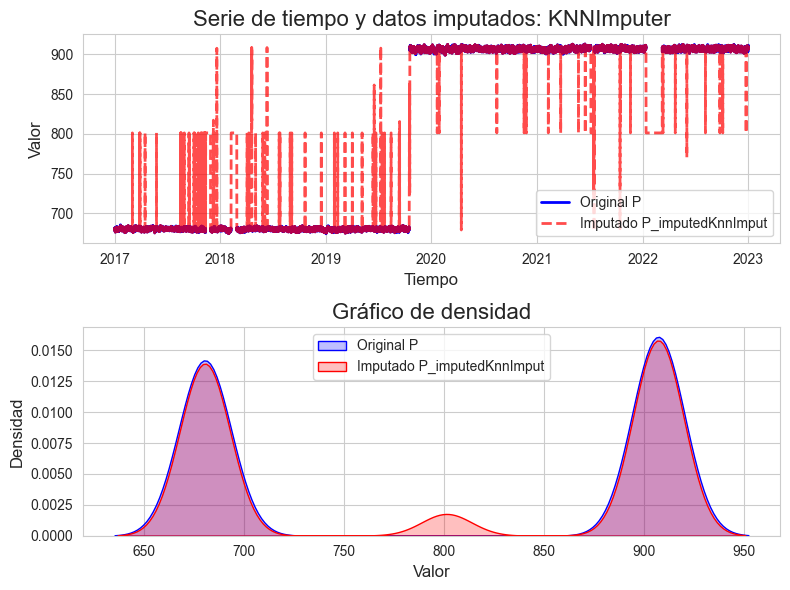

In [41]:
plot_impute(df_combined1, 'P', 'P_imputedKnnImput',  'KNNImputer')

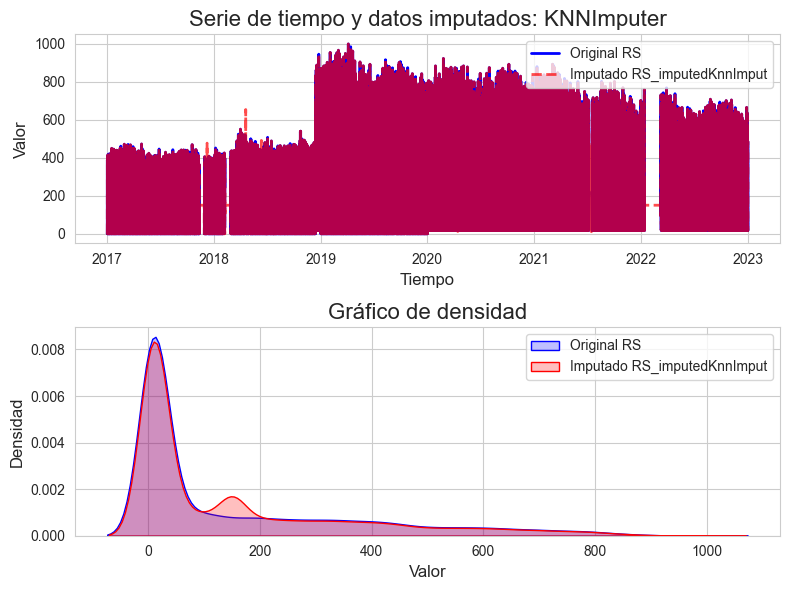

In [42]:
plot_impute(df_combined1, 'RS', 'RS_imputedKnnImput',  'KNNImputer')

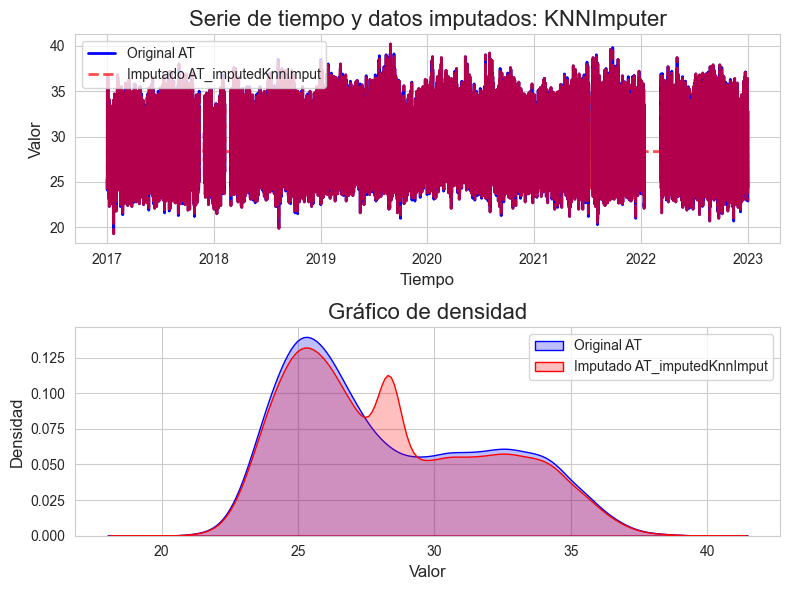

In [43]:
plot_impute(df_combined1, 'AT', 'AT_imputedKnnImput',  'KNNImputer')

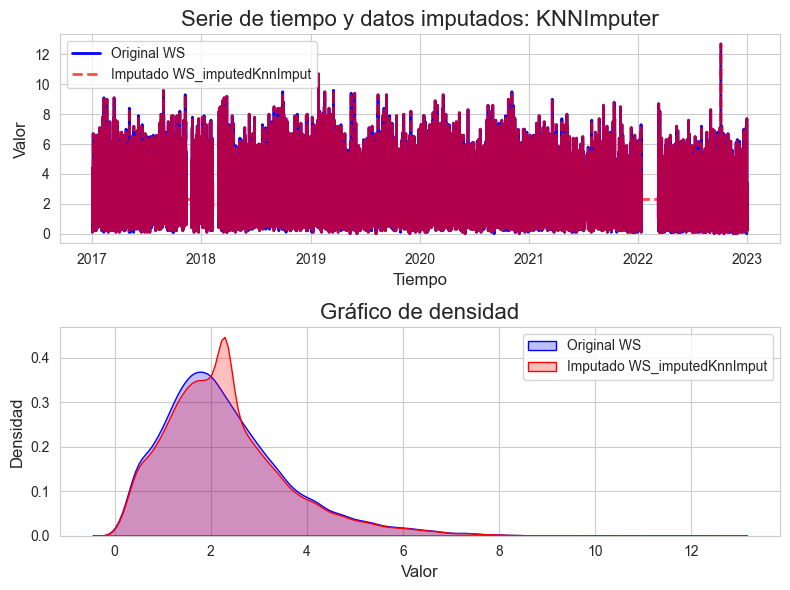

In [44]:
plot_impute(df_combined1, 'WS', 'WS_imputedKnnImput',  'KNNImputer')

### <font color="#30143"> Imputación Múltiple por Ecuaciones Encadenadas </font>

A continuación usaremos la función `IterativeImputer()`la cual modela una columna con valores faltantes como una función de las otras columnas. Esto se realiza en un proceso iterativo donde, en cada iteración, una columna se trata como la variable objetivo y las demás como predictores. Este enfoque permite aprovechar las relaciones entre las características para realizar imputaciones más precisas. 

A continuación se definen los argumentos más relevantes: 

* **estimator**: Este parámetro permite especificar el estimador que se utilizará para imputar los valores faltantes. Puede ser cualquier regresor compatible con Scikit-learn. Si no se proporciona, se utiliza por defecto un `BayesianRidge()`. Dada la naturaleza de nuestros datos usaremos `RandomForestRegressor()`.

* **n_nearest_features**: Indica el número de características más cercanas que se usarán para imputar un valor faltante. Si es `None`, se utilizan todas las características.
  
*  **initial_strategy**: Estrategia inicial para imputar valores antes de comenzar el proceso iterativo. Las opciones incluyen `mean`, `median`, y `most_frequent`.
  
* **max_iter**: Establece el número máximo de iteraciones que el algoritmo realizará para imputar los valores faltantes.
  
* **imputation_order**: Define el orden en el que se imputan las características. Las opciones son `ascending`, `descending`, `roman`, y `random`.

#### <font color="#30143"> Imputación usando KNeighborsRegressor()</font>

In [111]:
import pandas as pd
from numpy import isnan
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor

# Separar las columnas numéricas y no numéricas
df_non_numeric = df_compartir_drop[['fecha', 'estacion']]
df_numeric = df_compartir_drop.drop(columns=['fecha', 'estacion'])

# Inicializa el regresor KNeighbors
regressor_knn = KNeighborsRegressor()
imputer2 = IterativeImputer(random_state=0, max_iter=10, n_nearest_features=None, 
                           imputation_order='ascending', initial_strategy='median', estimator=regressor_knn)

# Imputa solo las columnas numéricas
df_imputed_array2 = imputer2.fit_transform(df_numeric)

# Crear un DataFrame a partir del array de NumPy, especificando las columnas
df_imputer2 = pd.DataFrame(df_imputed_array2, columns=df_numeric.columns, index=df_numeric.index)

# Añadir sufijo a las columnas imputadas
df_imputer2.columns = [col + '_imputedKNNregressor' for col in df_imputer2.columns]

# Concatenar el DataFrame original completo con el DataFrame imputado
df_combined2 = pd.concat([df_compartir_drop, df_imputer2], axis=1)

# Mostrar las primeras filas del DataFrame combinado
print(df_combined2.head())

                       fecha   estacion     WD    HR   RF        O3   PM10  \
2  2017-01-01 00:59:59+00:00  compartir  208.6  75.9  0.0  8.456252  221.0   
11 2017-01-01 01:59:59+00:00  compartir   65.2  77.3  0.0  8.240431  229.0   
20 2017-01-01 02:59:59+00:00  compartir   86.8  77.6  0.0  6.651205  136.0   
29 2017-01-01 03:59:59+00:00  compartir  216.0  79.2  0.0  5.984123  101.0   
38 2017-01-01 04:59:59+00:00  compartir  271.8  79.9  0.0  6.513865   90.0   

    PM2.5      P   RS  ...  WD_imputedKNNregressor  HR_imputedKNNregressor  \
2   161.0  680.5  0.0  ...                   208.6                    75.9   
11  147.0  680.0  0.0  ...                    65.2                    77.3   
20   78.0  679.5  0.0  ...                    86.8                    77.6   
29   46.0  679.5  0.0  ...                   216.0                    79.2   
38   54.0  679.8  0.0  ...                   271.8                    79.9   

    RF_imputedKNNregressor  O3_imputedKNNregressor  PM10_imput

In [117]:
df_combined2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52584 entries, 2 to 473249
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   fecha                      52584 non-null  datetime64[ns, UTC]
 1   estacion                   52584 non-null  object             
 2   WD                         49551 non-null  float64            
 3   HR                         45533 non-null  float64            
 4   RF                         49550 non-null  float64            
 5   O3                         35142 non-null  float64            
 6   PM10                       38283 non-null  float64            
 7   PM2.5                      32780 non-null  float64            
 8   P                          49550 non-null  float64            
 9   RS                         49395 non-null  float64            
 10  AT                         49542 non-null  float64            
 11  WS    

A continuación se aplicará la prueba U de Mann-Whitney para comparar la distribución de los datos originales con valores faltantes y los datos imputados. La hipótesis nula de la prueba es que las dos muestras (datos originales y datos imputados) provienen de la misma distribución.  

Un resultado no significativo (p-valor alto) indicaría que no hay evidencia suficiente para rechazar la hipótesis nula, sugiriendo que la imputación no ha alterado significativamente la distribución de los datos originales.

* Si el p-valor es alto: Esto indicaría que las distribuciones de los datos originales y los datos imputados son similares, lo que sugiere que la imputación ha mantenido las características estadísticas de los datos originales, validando así la adecuación del proceso de imputación.
  
* Si el p-valor es bajo: Esto sugeriría que las distribuciones son diferentes, lo que podría indicar que la imputación ha introducido sesgos o alteraciones significativas en los datos.

In [118]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Excluir las columnas que no se deben incluir en la prueba
columns_to_exclude = ['fecha', 'estacion']

# Seleccionar solo las columnas numéricas originales y sus correspondientes imputadas
original_columns = [col for col in df_combined2.columns if col not in columns_to_exclude and not col.endswith('_imputedKNNregressor')]
imputed_columns = [col for col in df_combined2.columns if col.endswith('_imputedKNNregressor')]

# Iterar sobre las columnas originales e imputadas correspondientes
for original_col in original_columns:
    imputed_col = original_col + '_imputedKNNregressor'
    
    if imputed_col in imputed_columns:
        # Asegurarse de que la columna existe en el DataFrame
        original_data = df_combined2[original_col].dropna()
        imputed_data = df_combined2[imputed_col].dropna()
        
        # Realizar la prueba de Mann-Whitney U
        stat, p_value = mannwhitneyu(original_data, imputed_data, alternative='two-sided')
        
        print(f"Atributo '{original_col}':")
        print(f"Mann-Whitney U Test: statistic={stat:.2f}, p-value={p_value:.4f}")
        print()  # Línea en blanco para separar los resultados de cada columna
        
        # Interpretar el resultado
        alpha = 0.05  # Nivel de significancia
        if p_value < alpha:
            print(f"Diferencia significativa detectada (p-valor < {alpha})")
        else:
            print(f"No se detectó diferencia significativa (p-valor ≥ {alpha})")
        
        print()  # Línea en blanco para separar los resultados de cada columna

Atributo 'WD':
Mann-Whitney U Test: statistic=1308569105.00, p-value=0.2201

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'HR':
Mann-Whitney U Test: statistic=1227697376.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'RF':
Mann-Whitney U Test: statistic=1307504158.50, p-value=0.0243

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'O3':
Mann-Whitney U Test: statistic=925378298.50, p-value=0.6983

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'PM10':
Mann-Whitney U Test: statistic=1020657290.50, p-value=0.0003

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'PM2.5':
Mann-Whitney U Test: statistic=869609910.00, p-value=0.0267

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'P':
Mann-Whitney U Test: statistic=1307138332.50, p-value=0.3534

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'RS':
Mann-Whitney U Test: statistic=1261507907.00, p-value=0.0000


Dados los resultados obtenidos de la prueba `U de Mann-Whitney`, se observa que, con la excepción del atributo `WD`, `O3` y `P`, todos los demás atributos presentan un `p-valor` inferior a $0.05$. Lo que sugiere que existen diferencias significativas entre las distribuciones de los datos originales y los datos imputados. Lo que indica que el proceso de imputación ha alterado significativamente las características estadísticas de la mayoría de los atributos. 

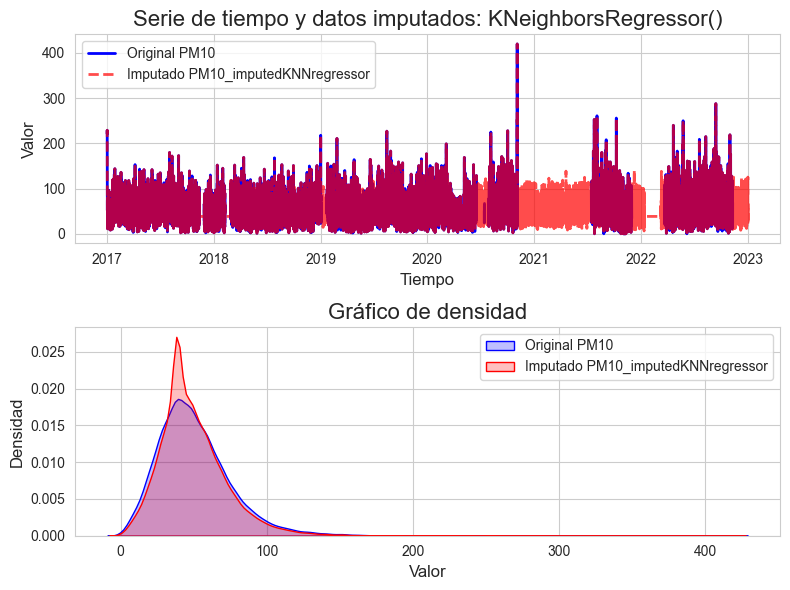

In [119]:
plot_impute(df_combined2, 'PM10', 'PM10_imputedKNNregressor',  'KNeighborsRegressor()')

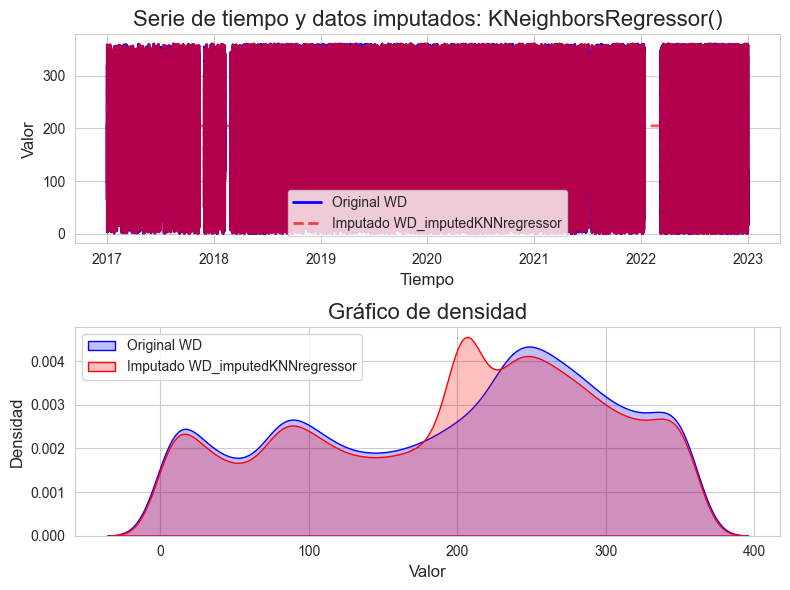

In [53]:
plot_impute(df_combined2, 'WD', 'WD_imputedKNNregressor',  'KNeighborsRegressor()')

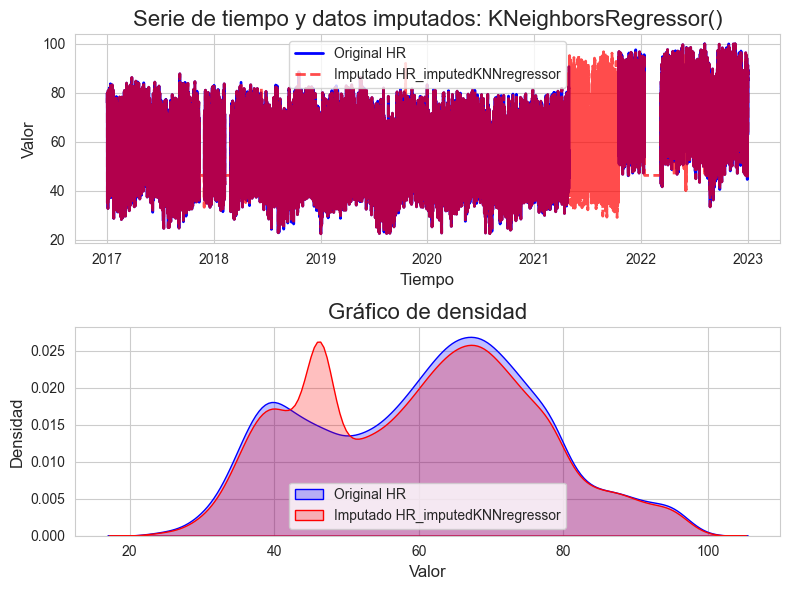

In [54]:
plot_impute(df_combined2, 'HR', 'HR_imputedKNNregressor',  'KNeighborsRegressor()')

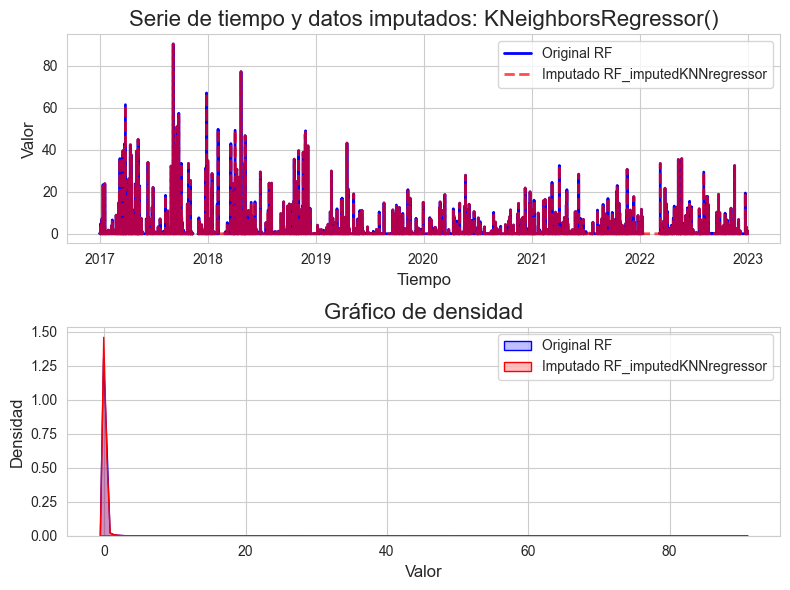

In [55]:
plot_impute(df_combined2, 'RF', 'RF_imputedKNNregressor',  'KNeighborsRegressor()')

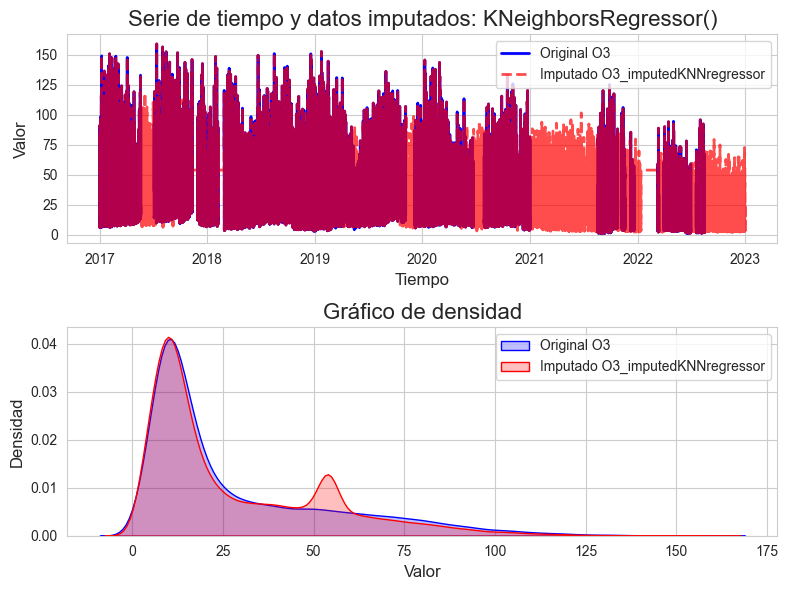

In [56]:
plot_impute(df_combined2, 'O3', 'O3_imputedKNNregressor',  'KNeighborsRegressor()')

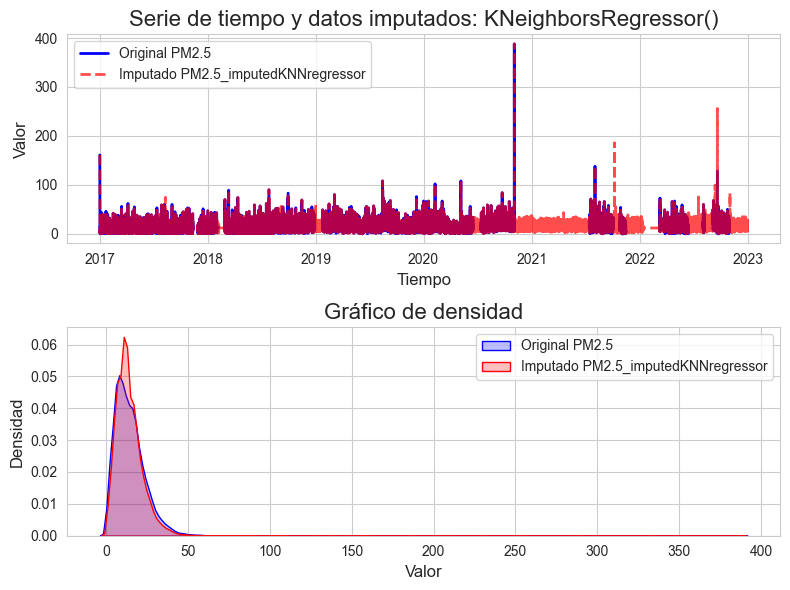

In [57]:
plot_impute(df_combined2, 'PM2.5', 'PM2.5_imputedKNNregressor',  'KNeighborsRegressor()')

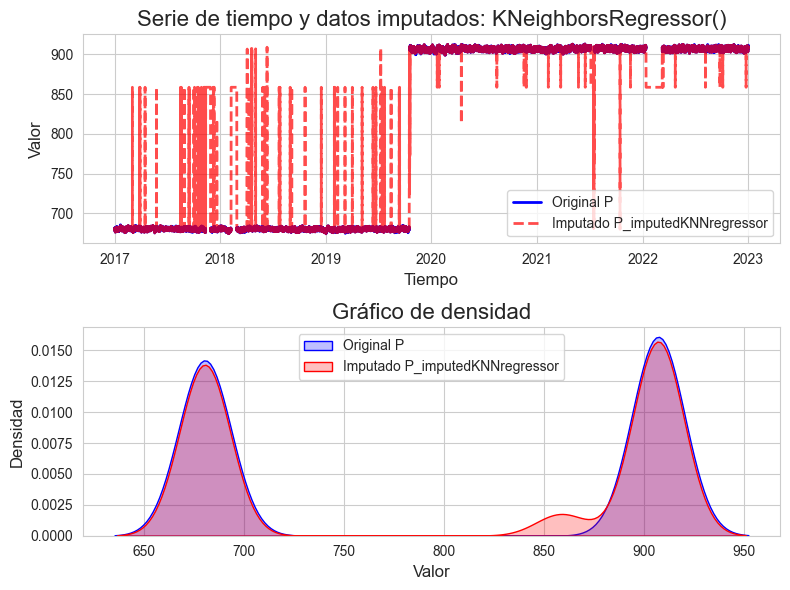

In [58]:
plot_impute(df_combined2, 'P', 'P_imputedKNNregressor',  'KNeighborsRegressor()')

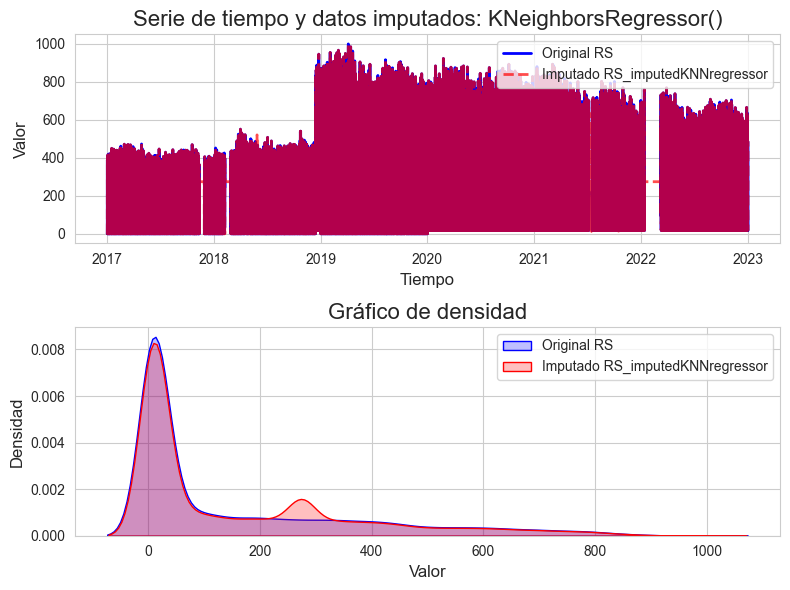

In [59]:
plot_impute(df_combined2, 'RS', 'RS_imputedKNNregressor',  'KNeighborsRegressor()')

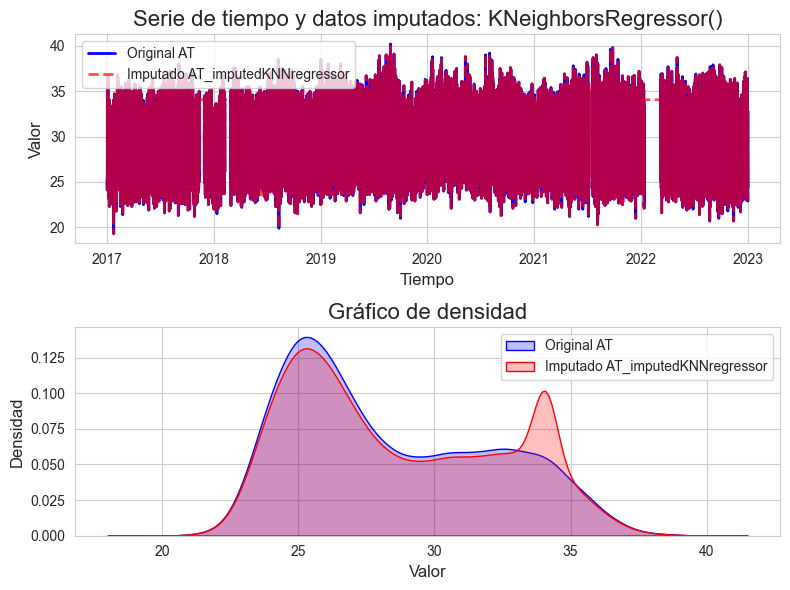

In [60]:
plot_impute(df_combined2, 'AT', 'AT_imputedKNNregressor',  'KNeighborsRegressor()')

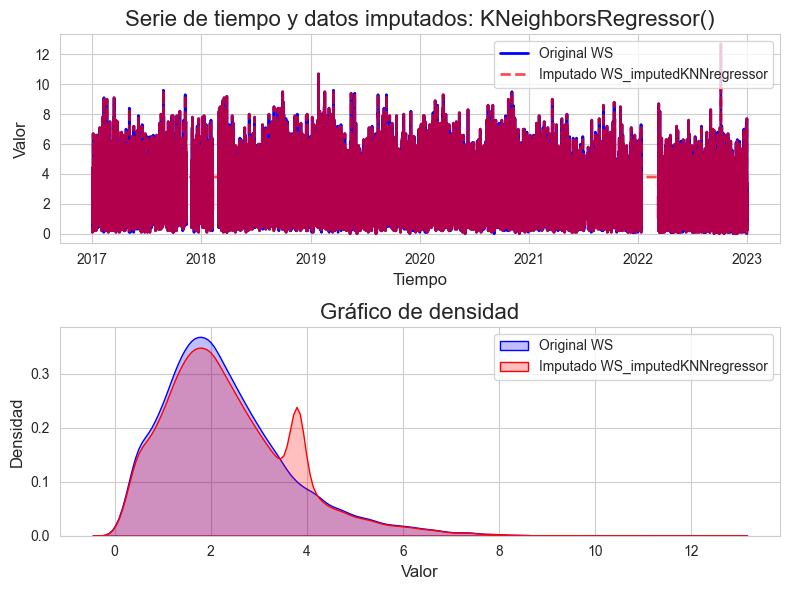

In [61]:
plot_impute(df_combined2, 'WS', 'WS_imputedKNNregressor',  'KNeighborsRegressor()')

#### <font color="#30143"> Imputación usando RandomForestRegressor()</font>

In [76]:
import pandas as pd
from numpy import isnan
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Separar las columnas numéricas y no numéricas
df_numeric = df_compartir_drop.select_dtypes(include=['float64', 'int64'])
df_non_numeric = df_compartir_drop.select_dtypes(exclude=['float64', 'int64'])

# Inicializa el regresor RandomForest
regressor_rf = RandomForestRegressor()
imputer3 = IterativeImputer(random_state=0, max_iter=10, n_nearest_features=None, 
                           imputation_order='ascending', initial_strategy='median', estimator=regressor_rf)

# Imputa solo las columnas numéricas
df_imputed_array3 = imputer3.fit_transform(df_numeric)

# Crear un DataFrame a partir del array de NumPy, especificando las columnas y manteniendo el índice original
df_imputer3 = pd.DataFrame(df_imputed_array3, columns=df_numeric.columns, index=df_numeric.index)

# Añadir sufijo a las columnas imputadas
df_imputer3.columns = [col + '_imputedRFregressor' for col in df_imputer3.columns]

# Concatenar el DataFrame original completo con el DataFrame imputado
df_combined3 = pd.concat([df_compartir_drop, df_imputer3], axis=1)

# Mostrar las primeras filas del DataFrame combinado
print(df_combined3.head())

                       fecha   estacion     WD    HR   RF        O3   PM10  \
2  2017-01-01 00:59:59+00:00  compartir  208.6  75.9  0.0  8.456252  221.0   
11 2017-01-01 01:59:59+00:00  compartir   65.2  77.3  0.0  8.240431  229.0   
20 2017-01-01 02:59:59+00:00  compartir   86.8  77.6  0.0  6.651205  136.0   
29 2017-01-01 03:59:59+00:00  compartir  216.0  79.2  0.0  5.984123  101.0   
38 2017-01-01 04:59:59+00:00  compartir  271.8  79.9  0.0  6.513865   90.0   

    PM2.5      P   RS  ...  WD_imputedRFregressor  HR_imputedRFregressor  \
2   161.0  680.5  0.0  ...                  208.6                   75.9   
11  147.0  680.0  0.0  ...                   65.2                   77.3   
20   78.0  679.5  0.0  ...                   86.8                   77.6   
29   46.0  679.5  0.0  ...                  216.0                   79.2   
38   54.0  679.8  0.0  ...                  271.8                   79.9   

    RF_imputedRFregressor  O3_imputedRFregressor  PM10_imputedRFregressor 

A continuación se aplicará la prueba U de Mann-Whitney para comparar la distribución de los datos originales con valores faltantes y los datos imputados. La hipótesis nula de la prueba es que las dos muestras (datos originales y datos imputados) provienen de la misma distribución.  

Un resultado no significativo (p-valor alto) indicaría que no hay evidencia suficiente para rechazar la hipótesis nula, sugiriendo que la imputación no ha alterado significativamente la distribución de los datos originales.

* Si el p-valor es alto: Esto indicaría que las distribuciones de los datos originales y los datos imputados son similares, lo que sugiere que la imputación ha mantenido las características estadísticas de los datos originales, validando así la adecuación del proceso de imputación.
  
* Si el p-valor es bajo: Esto sugeriría que las distribuciones son diferentes, lo que podría indicar que la imputación ha introducido sesgos o alteraciones significativas en los datos.

In [77]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Excluir las columnas que no se deben incluir en la prueba
columns_to_exclude = ['fecha', 'estacion']

# Seleccionar solo las columnas numéricas originales y sus correspondientes imputadas
original_columns = [col for col in df_combined3.columns if col not in columns_to_exclude and not col.endswith('_imputedRFregressor')]
imputed_columns = [col for col in df_combined3.columns if col.endswith('_imputedRFregressor')]

# Iterar sobre las columnas originales e imputadas correspondientes
for original_col in original_columns:
    imputed_col = original_col + '_imputedRFregressor'
    
    if imputed_col in imputed_columns:
        # Asegurarse de que la columna existe en el DataFrame
        original_data = df_combined3[original_col].dropna()
        imputed_data = df_combined3[imputed_col].dropna()
        
        # Realizar la prueba de Mann-Whitney U
        stat, p_value = mannwhitneyu(original_data, imputed_data, alternative='two-sided')
        
        print(f"Atributo '{original_col}':")
        print(f"Mann-Whitney U Test: statistic={stat:.2f}, p-value={p_value:.4f}")
        print()  # Línea en blanco para separar los resultados de cada columna
        
        # Interpretar el resultado
        alpha = 0.05  # Nivel de significancia
        if p_value < alpha:
            print(f"Diferencia significativa detectada (p-valor < {alpha})")
        else:
            print(f"No se detectó diferencia significativa (p-valor ≥ {alpha})")
        
        print()  # Línea en blanco para separar los resultados de cada columna

Atributo 'WD':
Mann-Whitney U Test: statistic=1288216715.50, p-value=0.0020

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'HR':
Mann-Whitney U Test: statistic=1207866134.50, p-value=0.0155

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'RF':
Mann-Whitney U Test: statistic=1237734940.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'O3':
Mann-Whitney U Test: statistic=927959446.50, p-value=0.2757

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'PM10':
Mann-Whitney U Test: statistic=990151748.50, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'PM2.5':
Mann-Whitney U Test: statistic=845168482.50, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'P':
Mann-Whitney U Test: statistic=1306504106.00, p-value=0.4276

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'RS':
Mann-Whitney U Test: statistic=1274661412.50, p-value=0.0000

Dife

Dados los resultados obtenidos de la prueba `U de Mann-Whitney`, se observa que, con la excepción del atributo  03 y P, todos los demás atributos presentan un `p-valor` inferior a $0.05$. Lo que sugiere que existen diferencias significativas entre las distribuciones de los datos originales y los datos imputados. Lo que indica que el proceso de imputación ha alterado significativamente las características estadísticas de la mayoría de los atributos. 

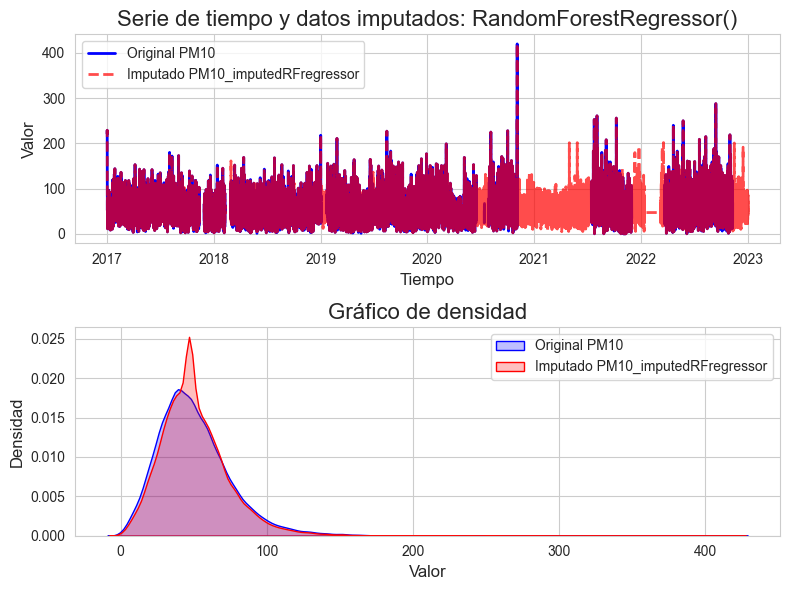

In [78]:
plot_impute(df_combined3, 'PM10', 'PM10_imputedRFregressor',  'RandomForestRegressor()')

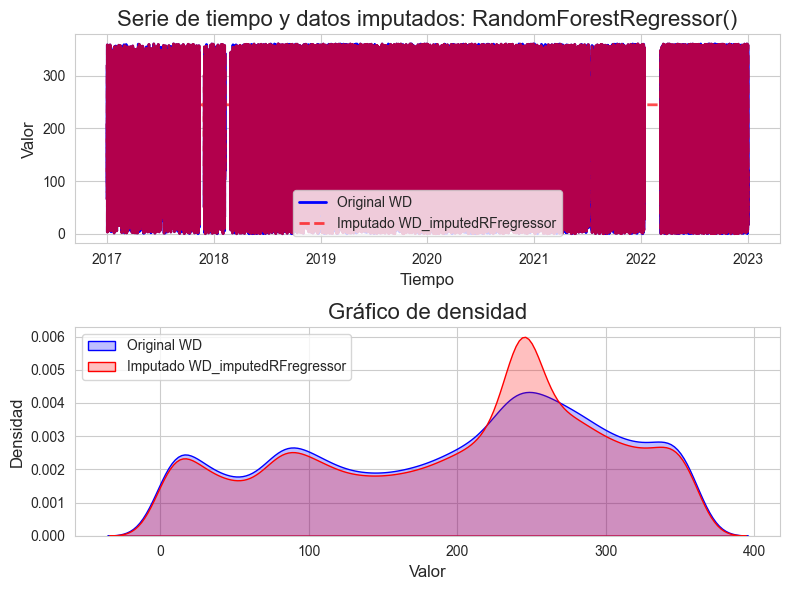

In [79]:
plot_impute(df_combined3, 'WD', 'WD_imputedRFregressor',  'RandomForestRegressor()')

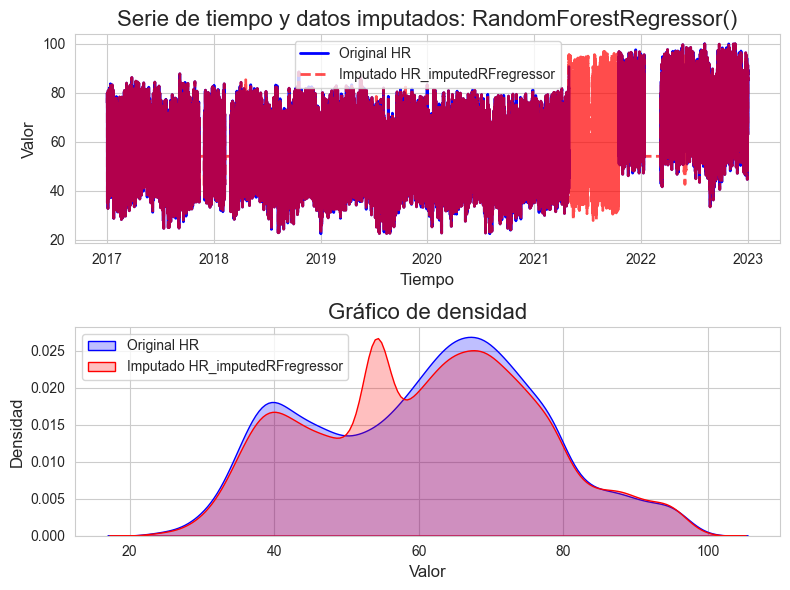

In [80]:
plot_impute(df_combined3, 'HR', 'HR_imputedRFregressor',  'RandomForestRegressor()')

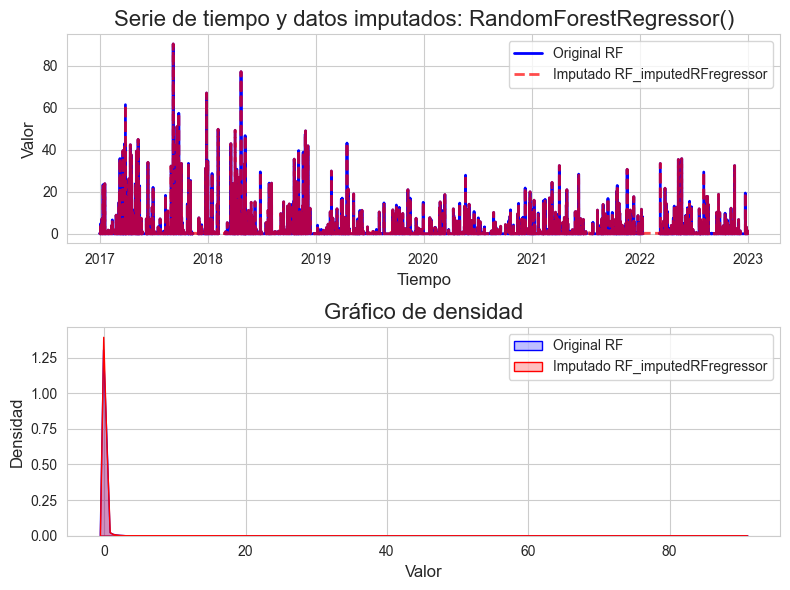

In [81]:
plot_impute(df_combined3, 'RF', 'RF_imputedRFregressor',  'RandomForestRegressor()')

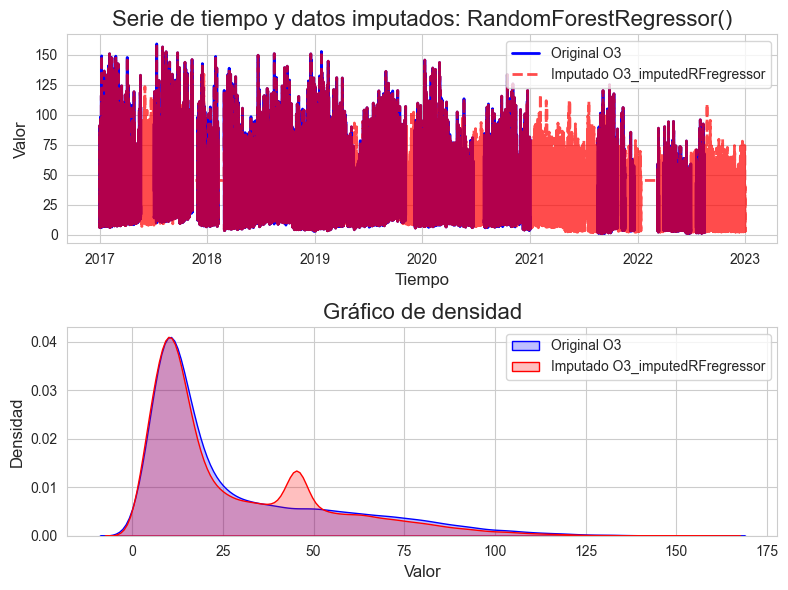

In [82]:
plot_impute(df_combined3, 'O3', 'O3_imputedRFregressor',  'RandomForestRegressor()')

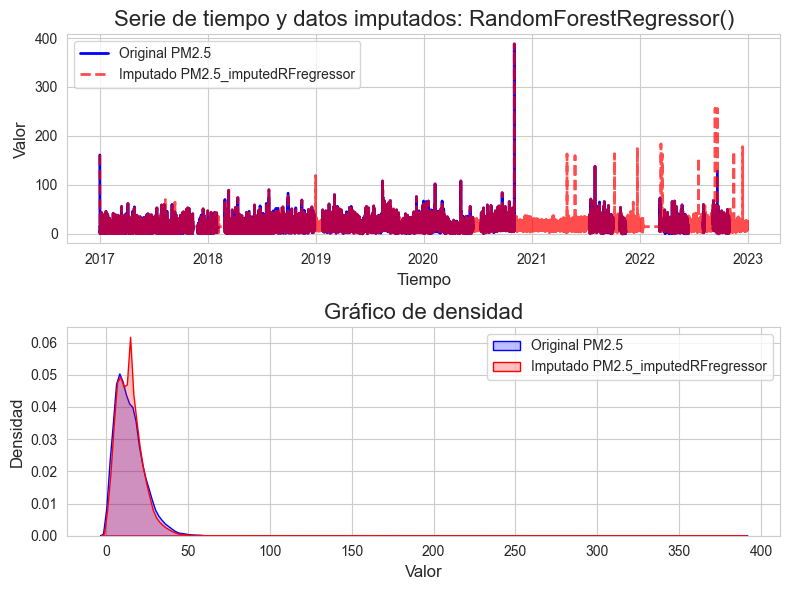

In [83]:
plot_impute(df_combined3, 'PM2.5', 'PM2.5_imputedRFregressor',  'RandomForestRegressor()')

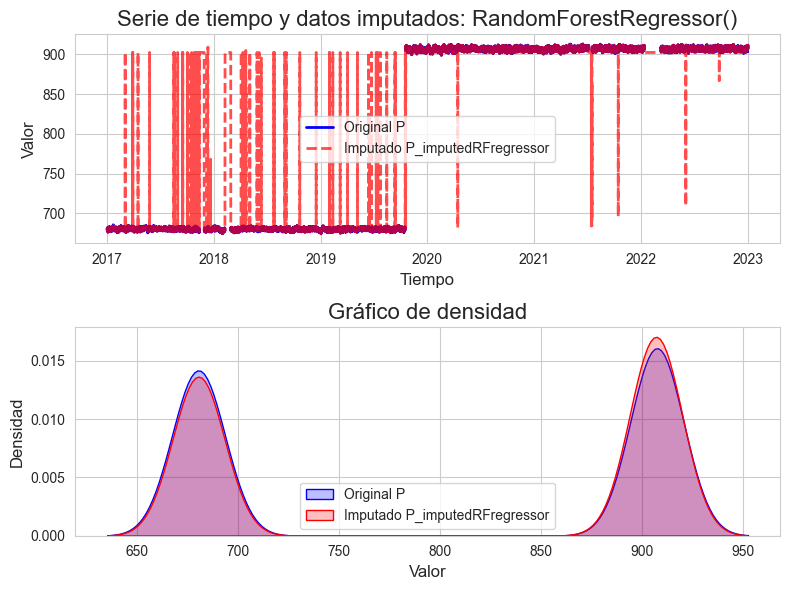

In [84]:
plot_impute(df_combined3, 'P', 'P_imputedRFregressor',  'RandomForestRegressor()')

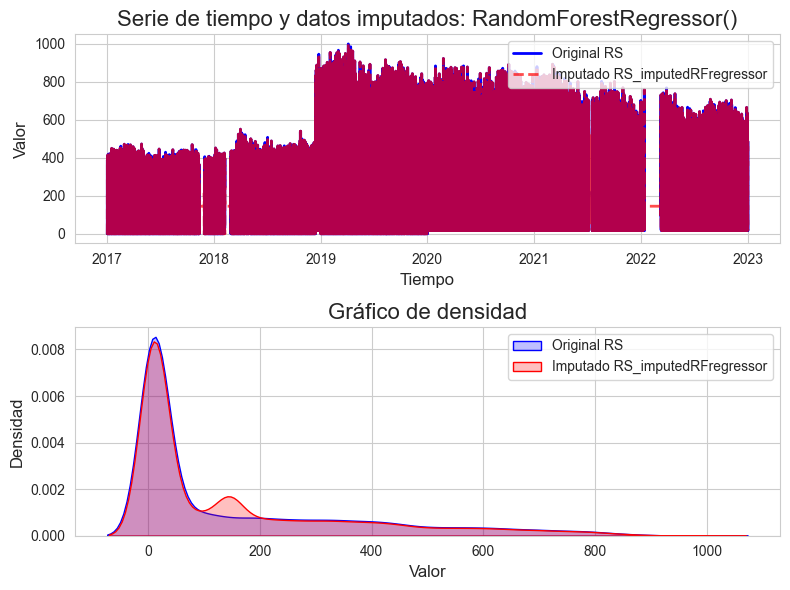

In [85]:
plot_impute(df_combined3, 'RS', 'RS_imputedRFregressor',  'RandomForestRegressor()')

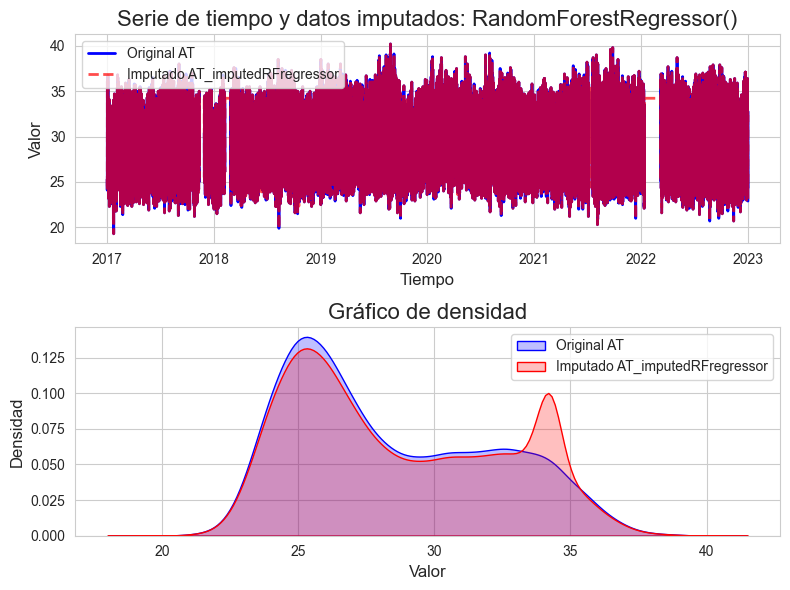

In [86]:
plot_impute(df_combined3, 'AT', 'AT_imputedRFregressor',  'RandomForestRegressor()')

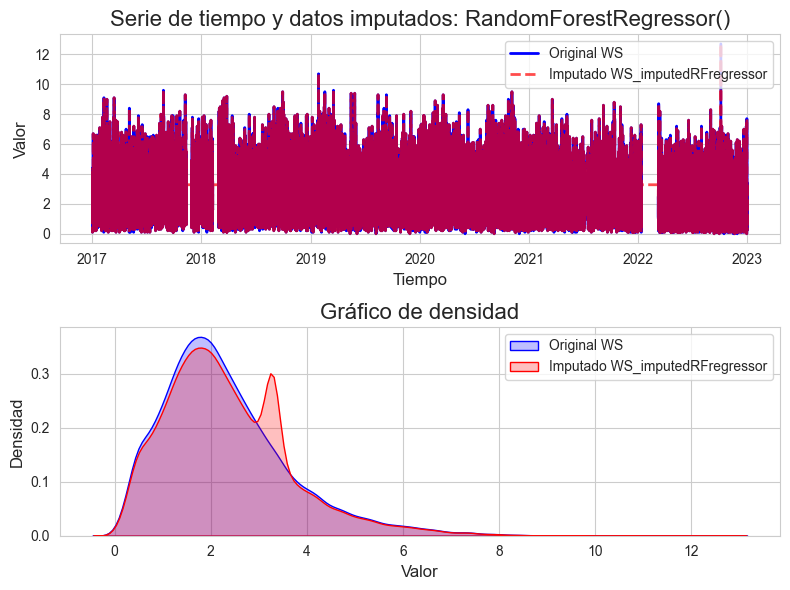

In [87]:
plot_impute(df_combined3, 'WS', 'WS_imputedRFregressor',  'RandomForestRegressor()')

#### <font color="#30143"> Imputación usando BayesianRidge() </font>

In [88]:
import pandas as pd
from numpy import isnan
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Separar las columnas numéricas y no numéricas
df_numeric = df_compartir_drop.select_dtypes(include=['float64', 'int64'])

# Inicializa el IterativeImputer (BayesianRidge es el estimador por defecto)
imputer4 = IterativeImputer(random_state=0, max_iter=10, n_nearest_features=None, 
                            imputation_order='ascending', initial_strategy='median')

# Imputa solo las columnas numéricas
df_imputed_array4 = imputer4.fit_transform(df_numeric)

# Crear un DataFrame a partir del array de NumPy, especificando las columnas y manteniendo el índice original
df_imputer4 = pd.DataFrame(df_imputed_array4, columns=df_numeric.columns, index=df_numeric.index)

# Añadir sufijo a las columnas imputadas
df_imputer4.columns = [col + '_BayesianR' for col in df_imputer4.columns]

# Concatenar el DataFrame original completo con el DataFrame imputado
df_combined4 = pd.concat([df_compartir_drop, df_imputer4], axis=1)

# Mostrar las primeras filas del DataFrame combinado
print(df_combined4.head())


                       fecha   estacion     WD    HR   RF        O3   PM10  \
2  2017-01-01 00:59:59+00:00  compartir  208.6  75.9  0.0  8.456252  221.0   
11 2017-01-01 01:59:59+00:00  compartir   65.2  77.3  0.0  8.240431  229.0   
20 2017-01-01 02:59:59+00:00  compartir   86.8  77.6  0.0  6.651205  136.0   
29 2017-01-01 03:59:59+00:00  compartir  216.0  79.2  0.0  5.984123  101.0   
38 2017-01-01 04:59:59+00:00  compartir  271.8  79.9  0.0  6.513865   90.0   

    PM2.5      P   RS  ...  WD_BayesianR  HR_BayesianR  RF_BayesianR  \
2   161.0  680.5  0.0  ...         208.6          75.9           0.0   
11  147.0  680.0  0.0  ...          65.2          77.3           0.0   
20   78.0  679.5  0.0  ...          86.8          77.6           0.0   
29   46.0  679.5  0.0  ...         216.0          79.2           0.0   
38   54.0  679.8  0.0  ...         271.8          79.9           0.0   

    O3_BayesianR  PM10_BayesianR  PM2.5_BayesianR  P_BayesianR  RS_BayesianR  \
2       8.456252  

A continuación se aplicará la prueba U de Mann-Whitney para comparar la distribución de los datos originales con valores faltantes y los datos imputados. La hipótesis nula de la prueba es que las dos muestras (datos originales y datos imputados) provienen de la misma distribución.  

Un resultado no significativo (p-valor alto) indicaría que no hay evidencia suficiente para rechazar la hipótesis nula, sugiriendo que la imputación no ha alterado significativamente la distribución de los datos originales.

* Si el p-valor es alto: Esto indicaría que las distribuciones de los datos originales y los datos imputados son similares, lo que sugiere que la imputación ha mantenido las características estadísticas de los datos originales, validando así la adecuación del proceso de imputación.
  
* Si el p-valor es bajo: Esto sugeriría que las distribuciones son diferentes, lo que podría indicar que la imputación ha introducido sesgos o alteraciones significativas en los datos.

In [89]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Excluir las columnas que no se deben incluir en la prueba
columns_to_exclude = ['fecha', 'estacion']

# Seleccionar solo las columnas numéricas originales y sus correspondientes imputadas
original_columns = [col for col in df_combined4.columns if col not in columns_to_exclude and not col.endswith('_BayesianR')]
imputed_columns = [col for col in df_combined4.columns if col.endswith('_BayesianR')]

# Iterar sobre las columnas originales e imputadas correspondientes
for original_col in original_columns:
    imputed_col = original_col + '_BayesianR'
    
    if imputed_col in imputed_columns:
        # Asegurarse de que la columna existe en el DataFrame
        original_data = df_combined4[original_col].dropna()
        imputed_data = df_combined4[imputed_col].dropna()
        
        # Realizar la prueba de Mann-Whitney U
        stat, p_value = mannwhitneyu(original_data, imputed_data, alternative='two-sided')
        
        print(f"Atributo '{original_col}':")
        print(f"Mann-Whitney U Test: statistic={stat:.2f}, p-value={p_value:.4f}")
        print()  # Línea en blanco para separar los resultados de cada columna
        
        # Interpretar el resultado
        alpha = 0.05  # Nivel de significancia
        if p_value < alpha:
            print(f"Diferencia significativa detectada (p-valor < {alpha})")
        else:
            print(f"No se detectó diferencia significativa (p-valor ≥ {alpha})")
        
        print()  # Línea en blanco para separar los resultados de cada columna

Atributo 'WD':
Mann-Whitney U Test: statistic=1311903492.50, p-value=0.0531

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'HR':
Mann-Whitney U Test: statistic=1184800671.50, p-value=0.0052

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'RF':
Mann-Whitney U Test: statistic=1237288364.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'O3':
Mann-Whitney U Test: statistic=950852637.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'PM10':
Mann-Whitney U Test: statistic=964061451.50, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'PM2.5':
Mann-Whitney U Test: statistic=832959523.00, p-value=0.0000

Diferencia significativa detectada (p-valor < 0.05)

Atributo 'P':
Mann-Whitney U Test: statistic=1307692782.00, p-value=0.2957

No se detectó diferencia significativa (p-valor ≥ 0.05)

Atributo 'RS':
Mann-Whitney U Test: statistic=1275660738.50, p-value=0.0000

Dife

Dados los resultados obtenidos de la prueba `U de Mann-Whitney`, se observa que, con la excepción del atributo WD, AT y P, todos los demás atributos presentan un `p-valor` inferior a $0.05$. Lo que sugiere que existen diferencias significativas entre las distribuciones de los datos originales y los datos imputados. Lo que indica que el proceso de imputación ha alterado significativamente las características estadísticas de la mayoría de los atributos. 

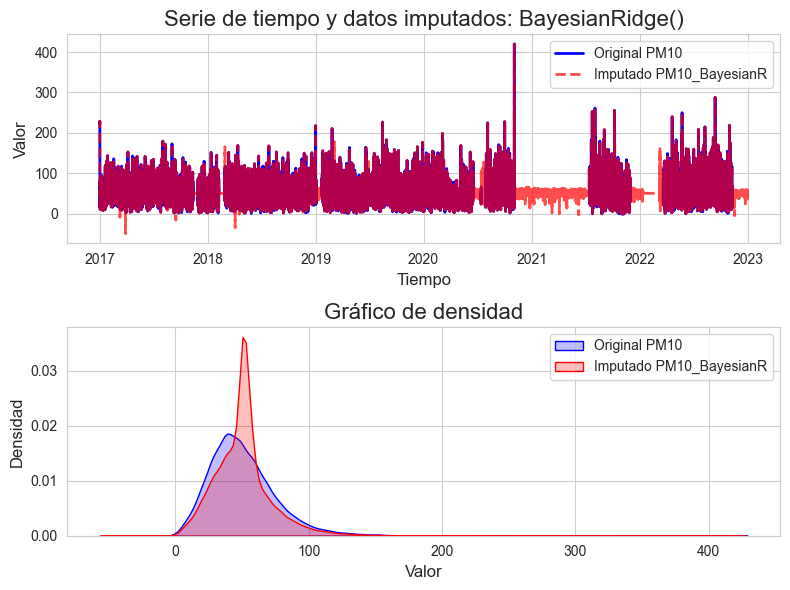

In [90]:
plot_impute(df_combined4, 'PM10', 'PM10_BayesianR',  'BayesianRidge()')

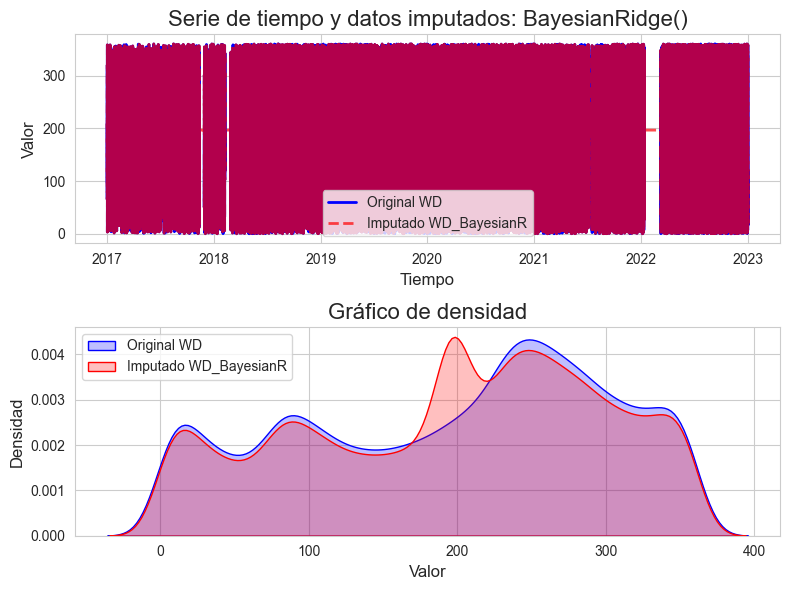

In [91]:
plot_impute(df_combined4, 'WD', 'WD_BayesianR',  'BayesianRidge()')

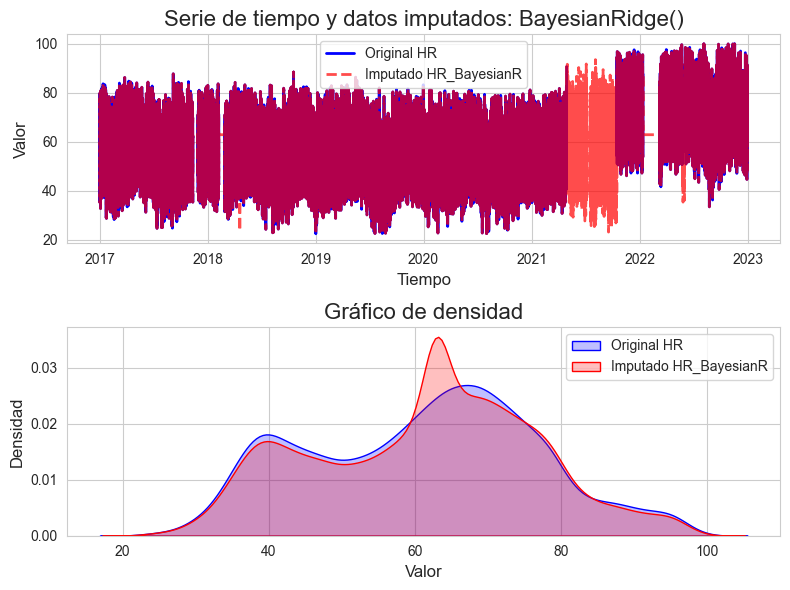

In [92]:
plot_impute(df_combined4, 'HR', 'HR_BayesianR',  'BayesianRidge()')

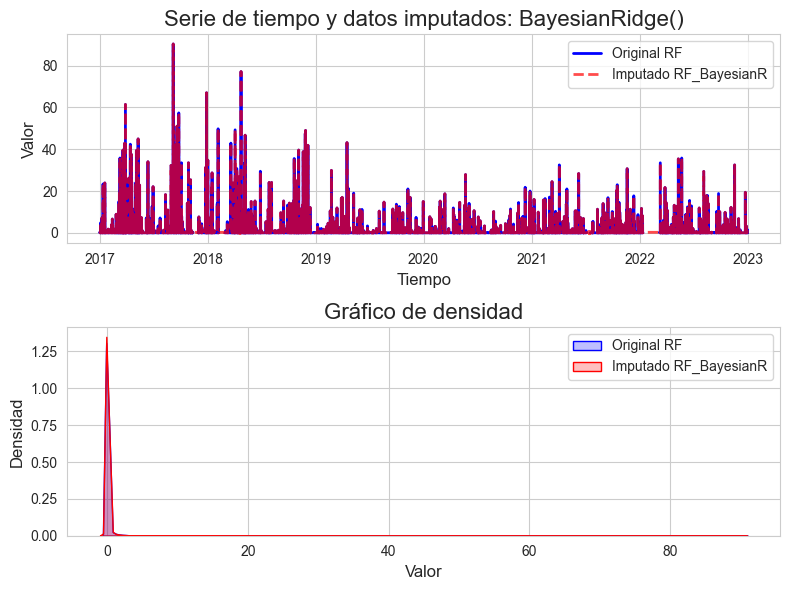

In [93]:
plot_impute(df_combined4, 'RF', 'RF_BayesianR',  'BayesianRidge()')

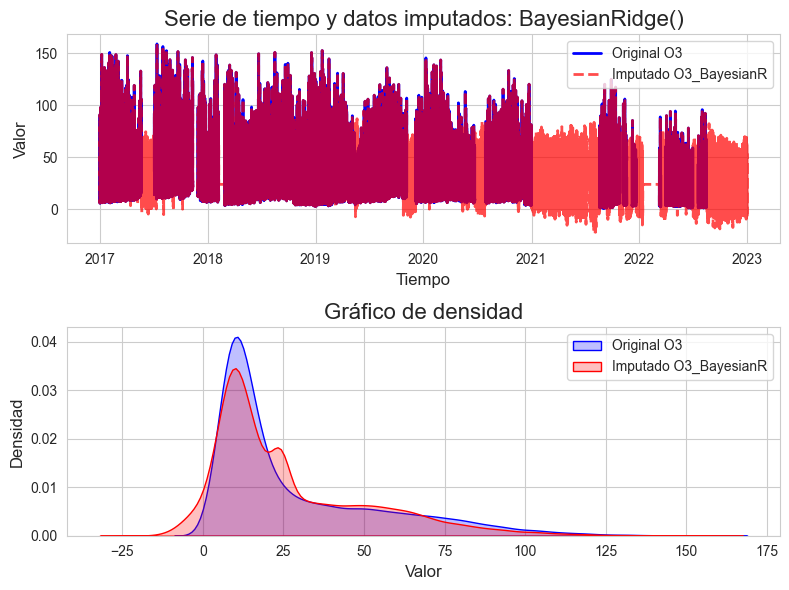

In [94]:
plot_impute(df_combined4, 'O3', 'O3_BayesianR',  'BayesianRidge()')

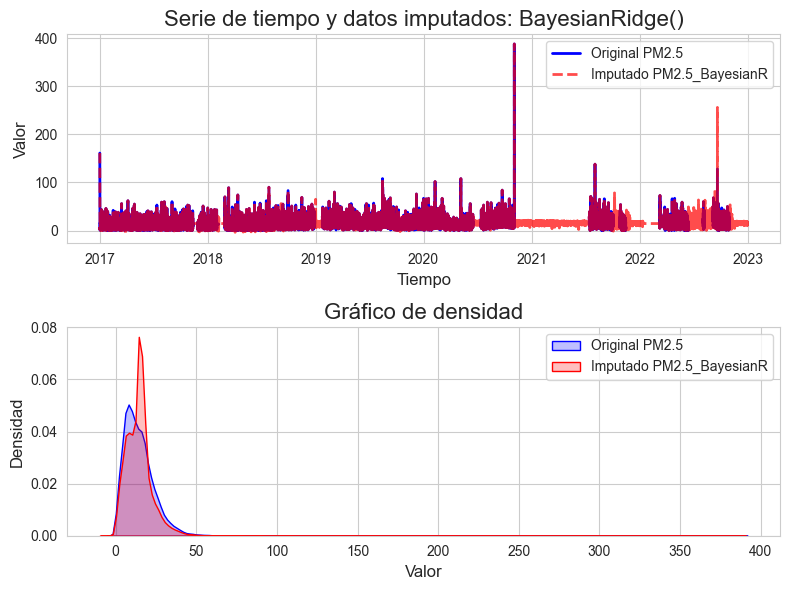

In [95]:
plot_impute(df_combined4, 'PM2.5', 'PM2.5_BayesianR',  'BayesianRidge()')

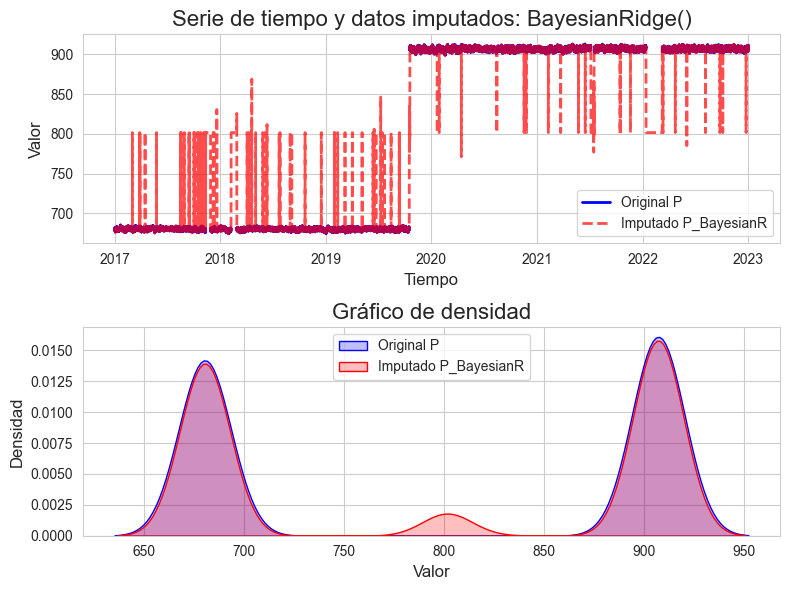

In [96]:
plot_impute(df_combined4, 'P', 'P_BayesianR',  'BayesianRidge()')

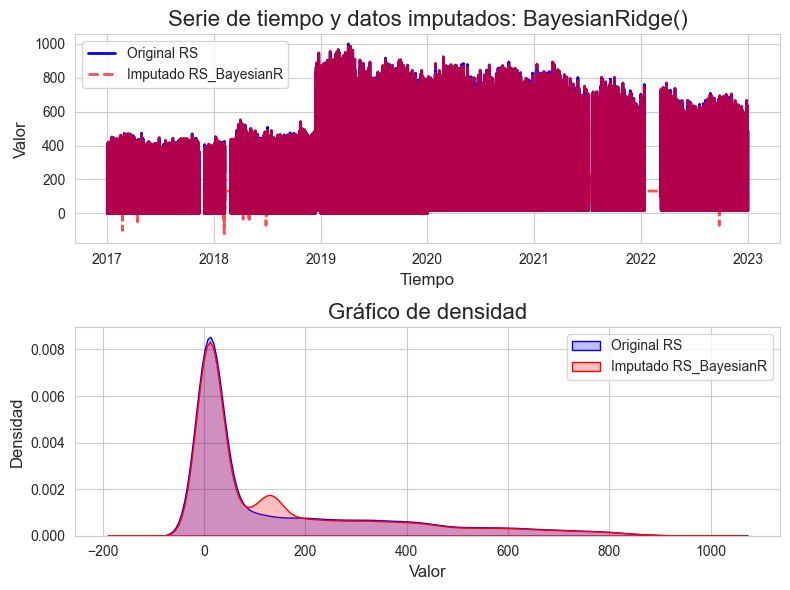

In [97]:
plot_impute(df_combined4, 'RS', 'RS_BayesianR',  'BayesianRidge()')

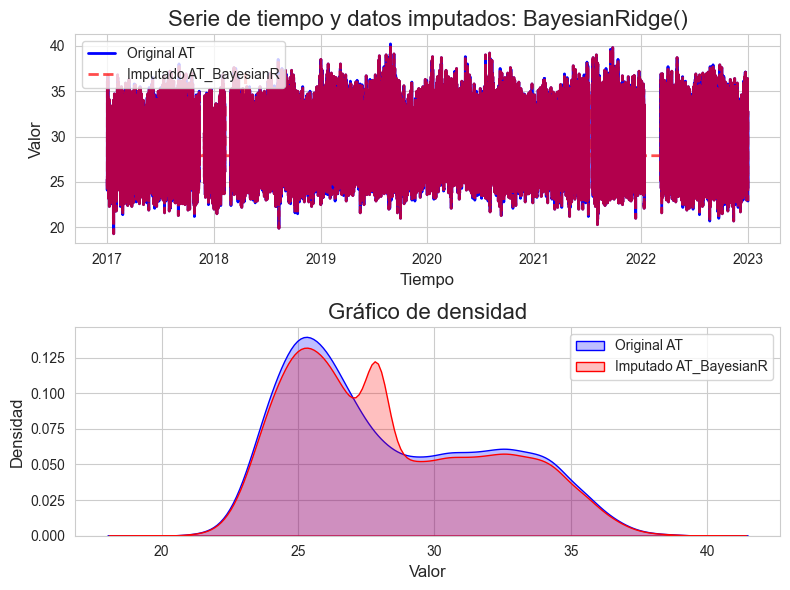

In [98]:
plot_impute(df_combined4, 'AT', 'AT_BayesianR',  'BayesianRidge()')

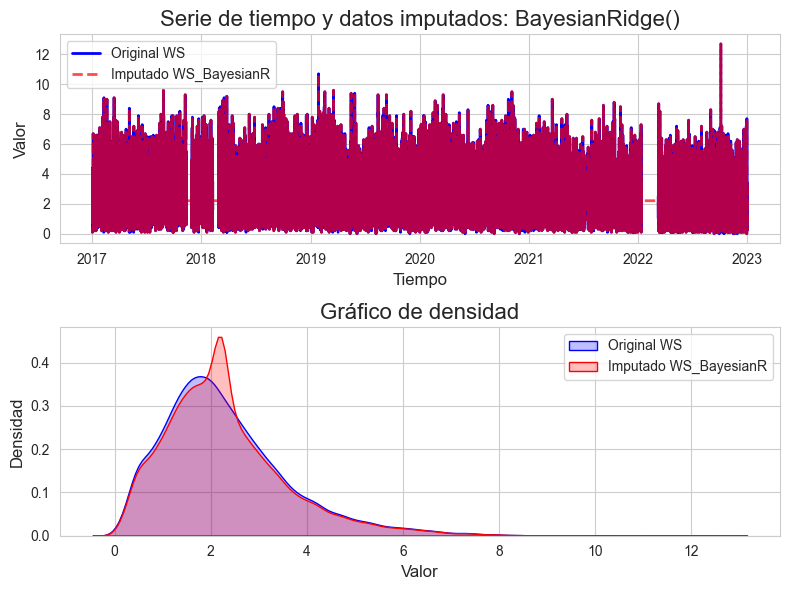

In [99]:
plot_impute(df_combined4, 'WS', 'WS_BayesianR',  'BayesianRidge()')

## <font color="#30143">  Descomposición de Series Temporales</font>

**Estacionalidad**: Una serie de tiempo tiene estacionalidad cuando alcanza picos y valles que se repiten periódicamente y de manera predecible en el tiempo. 

**Nivel**: Es el valor promedio de la serie a lo largo del tiempo.  

**Tendencia**: Es el nivel en la serie pero que cambia a lo largo del tiempo. 

La importancia de conocer estos componentes nos permiten:  
* Analizar o caracterizar la serie de tiempo.
* Construir modelos predictivos clásicos a partir de dichos componentes. 

Usaremos la descomposición de serie temporal `aditiva`, esta descomposición se usa cuando la magnitud del componente estacional se mantiene ligeramente constante a pesar de la tendencia. Matématicamente se expresa como $$y(t) = S(t) + T(t)+ R(t)$$
Para realizar esta descomposicón usamos la librería `statsmodels` a tráves de función `seasonal_descompose` especificando que haremos la descomposición con un modelo aditivo (`model = 'additive'`) y un periodo de 90 días. 

Frecuencia del índice: <Day>


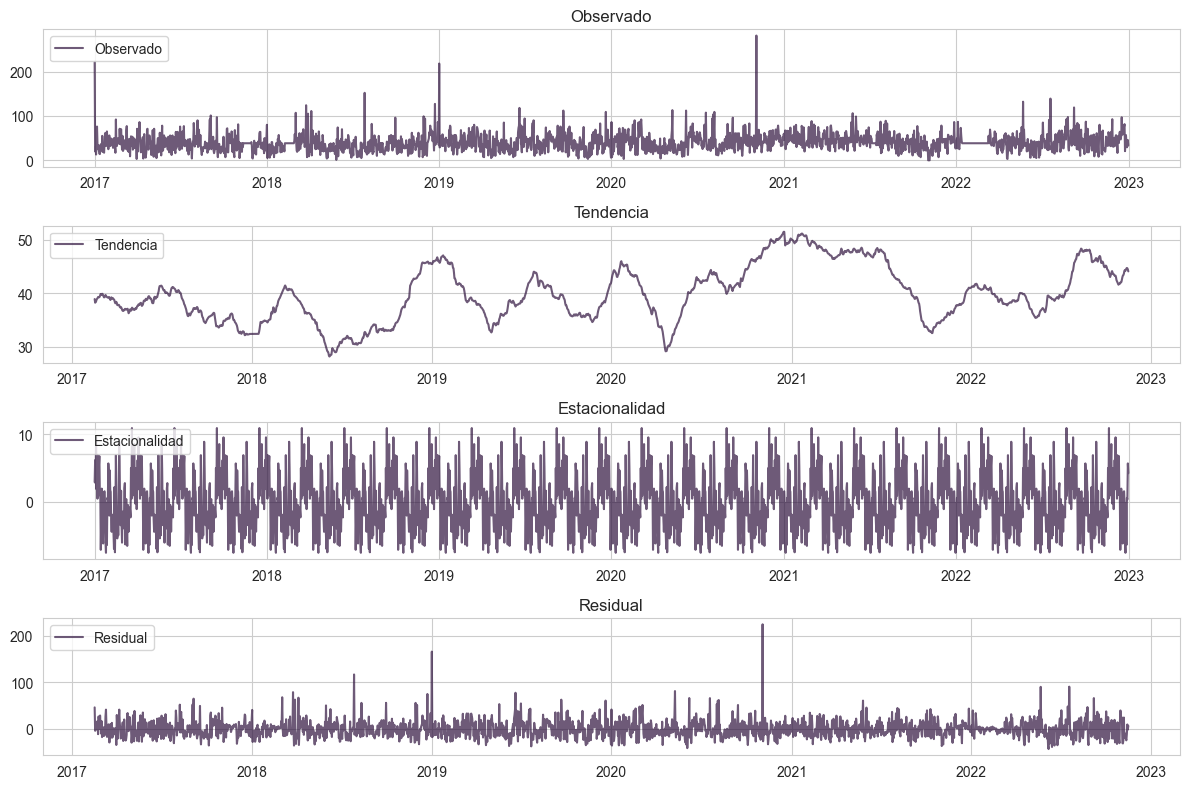

In [165]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


df_compartir_diario = df_combined2.copy()

# Convertir 'fecha' a tipo datetime
df_compartir_diario['fecha'] = pd.to_datetime(df_compartir_diario['fecha'])

# Establecer 'fecha' como índice
df_compartir_diario.set_index('fecha', inplace=True)

# Establecer la frecuencia del índice. Cambia 'D' a la frecuencia de tus datos si es necesario.
df_compartir_diario = df_compartir_diario.asfreq('D')  # 'D' para datos diarios, ajusta si es necesario

# Verificar la frecuencia del índice
print("Frecuencia del índice:", df_compartir_diario.index.freq)

periodo = 90  # Cambia esto según la estacionalidad esperada

# Realizar la descomposición estacional
decomposition = seasonal_decompose(df_compartir_diario['PM10_imputedKNNregressor'], model='aditive', period=periodo)

# Graficar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_compartir_diario['PM10_imputedKNNregressor'], label='Observado', color='#30143F', alpha=0.7)
plt.title('Observado')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendencia', color='#30143F', alpha=0.7)
plt.title('Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Estacionalidad', color='#30143F', alpha=0.7)
plt.title('Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='#30143F', alpha=0.7)
plt.title('Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


A continuación se realiza un análisis de cada uno de los componentes del gráfico: 

**Observado**: La serie temporal de PM10 ilustra cómo varían los niveles de concentración registrados desde 2017 hasta 2022. Este componente muestra el comportamiento general de los datos a lo largo del tiempo.

**Tendencia**: En el gráfico, se puede observar cómo los niveles de PM10 han cambiado a lo largo de los años, mostrando posibles incrementos o disminuciones a largo plazo. 

**Estacionalidad**: En el gráfico se puede observar que la emisión de PM10 durante el período evaluado presenta picos mínimos y máximos que reflejan una periodicidad clara. Esto indica la presencia de un componente estacional en los datos, evidenciando ciclos regulares en la concentración de PM10 a lo largo del tiempo.

**Residual**: En este gráfico se observan las variaciones que quedan después de eliminar la tendencia y la estacionalidad. Representa el ruido o las fluctuaciones aleatorias en los datos. 

A continuación se hace un análisis más detallado de los residuales a tráves de la estimación de la media de éstos. 

In [163]:
print(f'Promedio residuales descomposición aditivia:{decomposition.resid.mean()}')

Promedio residuales descomposición aditivia:-0.0075256530685298955


Dado el resultado anterior, podemos observar que la media negativa de $-0.007525$ en los residuos sugiere que, en promedio, estos son ligeramente inferiores a cero. Esta observación podría indicar la presencia de un sesgo leve en los datos o un pequeño desajuste en la serie temporal original. Es posible que esto se deba a variaciones naturales en los datos o a un componente de ruido aleatorio.

---